# From Overfitting to Generalization: Build a Robust Image Classifier

Machine learning models have a fundamental challenge: they need to perform well not just on data they've seen, but on new, unseen data. This notebook tackles the most common failure mode in machine learning - overfitting - where models memorize training data instead of learning generalizable patterns.

You'll work with real image data (Fashion-MNIST) and train actual neural networks to experience overfitting firsthand, learn to detect it early, understand why it happens, and master multiple techniques to fix it. 



## Learning Objectives

By completing this notebook, you will:
1. **Detect overfitting early** using validation sets and learning curves
2. **Understand the bias-variance tradeoff** through interactive visualizations
3. **Apply classical regularization techniques** (L1/L2, dropout, early stopping)
4. **Implement modern approaches** (label smoothing, mixup augmentation)
5. **Understand data-centric solutions** (quantity vs diversity for generalization)



## Setup and Dependencies

In [16]:
# Install and import all required libraries
%pip install -q tensorflow scikit-learn matplotlib seaborn ipywidgets yfinance

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
import ipywidgets as widgets
from IPython.display import display, clear_output

# For 2D demonstrations
from sklearn.datasets import make_moons, make_circles
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import train_test_split, learning_curve, validation_curve
from sklearn.model_selection import KFold, TimeSeriesSplit, cross_val_score

# For stock market demonstrations
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

# Configure visualization settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn-v0_8-darkgrid')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

Note: you may need to restart the kernel to use updated packages.


## Part 0: The Hook - Watch Your Model Fail

### Load Data and Create the Model

We'll use Fashion-MNIST, a dataset of clothing images. To guarantee overfitting, we'll use only 300 training samples with a complex model that has over 200,000 parameters.

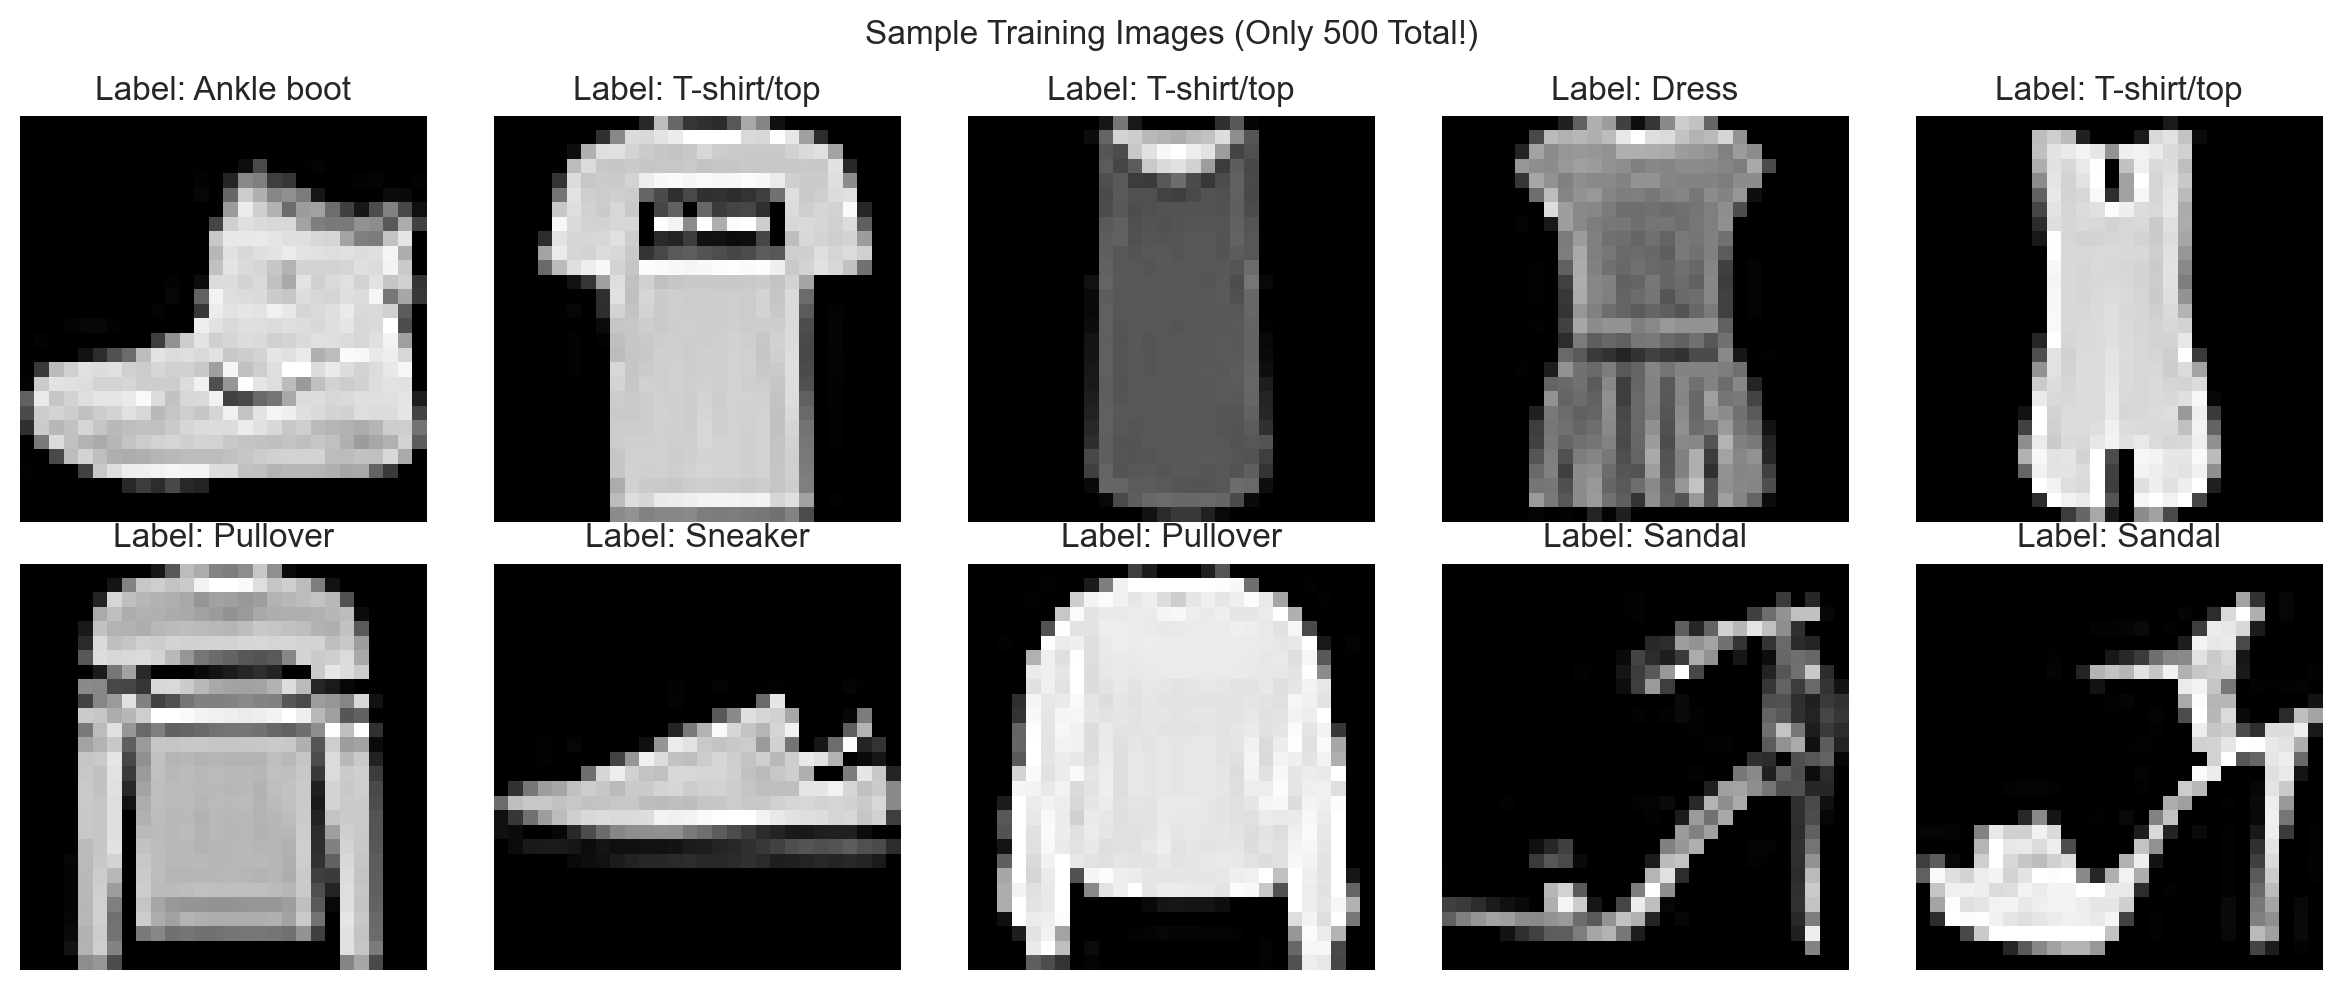

In [17]:
# Load Fashion-MNIST dataset
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Normalize exactly once and set dtypes
X_train_full = X_train_full.astype('float32') / 255.0
X_test       = X_test.astype('float32') / 255.0
y_train_full = y_train_full.astype('int32')
y_test       = y_test.astype('int32')

# Use only 300 samples to guarantee overfitting (no extra divide!)
n_samples = 300
X_train = X_train_full[:n_samples]
y_train = y_train_full[:n_samples]


# Class names for Fashion-MNIST
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Visualize sample training images
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i], cmap='gray')
    ax.set_title(f'Label: {class_names[y_train[i]]}')
    ax.axis('off')
plt.suptitle('Sample Training Images (Only 500 Total!)')
plt.tight_layout()
plt.show()

**Key Point:** With only 300 training samples and 10 classes, we have about 30 samples per class. This severely limited data will force our complex model to memorize rather than generalize.

In [18]:
def create_model():
    """Creates an overly complex neural network for our small dataset"""
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Count parameters to show model complexity
temp_model = create_model()
total_params = temp_model.count_params()
params_per_sample = total_params / len(X_train)

**Model Complexity Analysis:** This model has over 200,000 trainable parameters - that's 400+ parameters per training sample! This extreme overparameterization is a recipe for overfitting.

### Watch Overfitting Happen Live

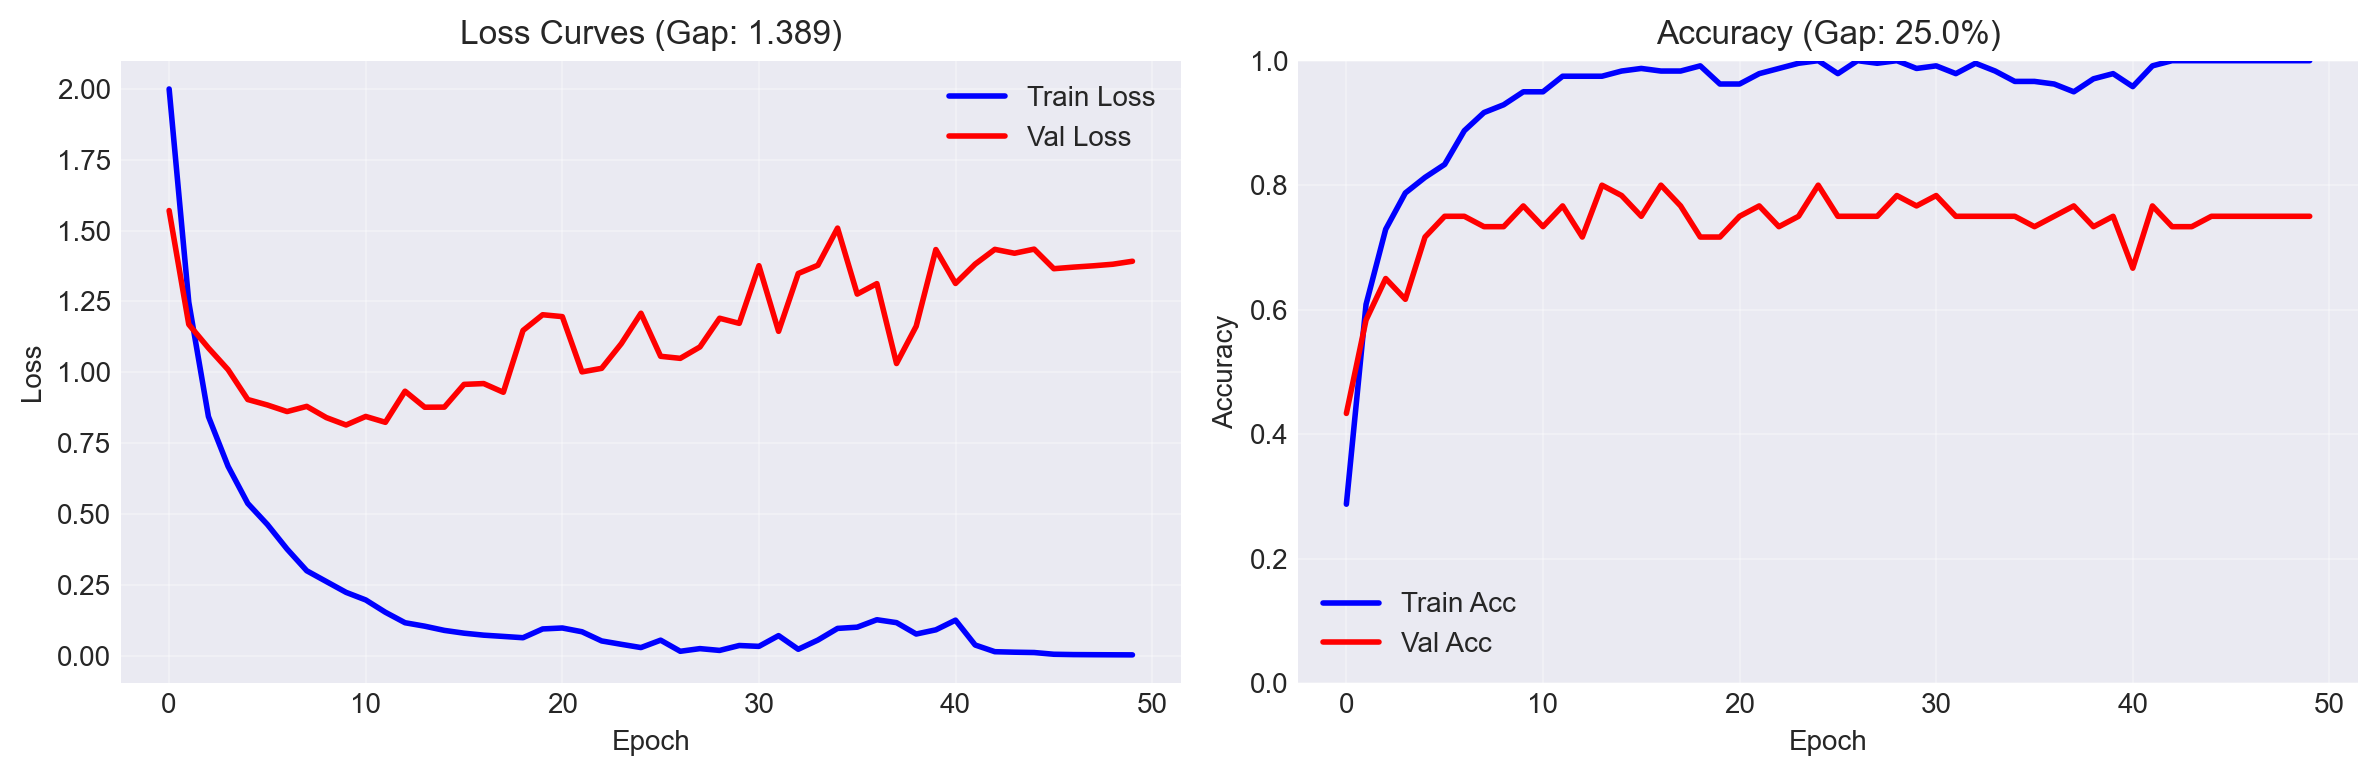

In [19]:
class LiveTrainingMonitor(tf.keras.callbacks.Callback):
    """Visualizes training progress in real-time to show overfitting"""
    def on_train_begin(self, logs={}):
        self.losses = {'train': [], 'val': []}
        self.accuracy = {'train': [], 'val': []}
        
    def on_epoch_end(self, epoch, logs={}):
        self.losses['train'].append(logs.get('loss'))
        self.losses['val'].append(logs.get('val_loss'))
        self.accuracy['train'].append(logs.get('accuracy'))
        self.accuracy['val'].append(logs.get('val_accuracy'))
        
        if epoch % 5 == 0 or epoch == 49:  # Update every 5 epochs
            clear_output(wait=True)
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
            
            # Plot losses
            ax1.plot(self.losses['train'], label='Train Loss', linewidth=2, color='blue')
            ax1.plot(self.losses['val'], label='Val Loss', linewidth=2, color='red')
            gap = self.losses['val'][-1] - self.losses['train'][-1]
            ax1.set_title(f'Loss Curves (Gap: {gap:.3f})')
            ax1.set_xlabel('Epoch')
            ax1.set_ylabel('Loss')
            ax1.legend()
            ax1.grid(True, alpha=0.3)
            
            # Plot accuracy with gap annotation
            ax2.plot(self.accuracy['train'], label='Train Acc', linewidth=2, color='blue')
            ax2.plot(self.accuracy['val'], label='Val Acc', linewidth=2, color='red')
            acc_gap = self.accuracy['train'][-1] - self.accuracy['val'][-1]
            ax2.set_title(f'Accuracy (Gap: {acc_gap:.1%})')
            ax2.set_xlabel('Epoch')
            ax2.set_ylabel('Accuracy')
            ax2.set_ylim([0, 1])
            ax2.legend()
            ax2.grid(True, alpha=0.3)
            
            # Add warning when overfitting is severe
            if epoch > 10 and acc_gap > 0.3:
                ax2.annotate('MEMORIZING!', xy=(epoch, self.accuracy['val'][-1]),
                           xytext=(epoch-10, 0.5), fontsize=14, color='red',
                           fontweight='bold',
                           arrowprops=dict(arrowstyle='->', color='red', lw=2))
            
            plt.tight_layout()
            plt.show()

# Train the disaster model
disaster_model = create_model()
monitor = LiveTrainingMonitor()


history_disaster = disaster_model.fit(
    X_train, y_train,
    validation_split=0.2,  # or create a val split from X_train_full
    epochs=50, batch_size=32, callbacks=[monitor], verbose=0
)

# Final results
final_train_acc = history_disaster.history['accuracy'][-1]
final_test_acc = history_disaster.history['val_accuracy'][-1]
generalization_gap = final_train_acc - final_test_acc

**Disaster Analysis:** The model achieved near-perfect training accuracy but terrible test accuracy. This massive generalization gap shows the model memorized the training data instead of learning useful patterns. In production, this model would fail catastrophically.



## Part 1: Detecting Overfitting with Validation

Before fixing overfitting, we need to detect it. Validation sets are our early warning system.

### Understanding Train/Validation/Test Splits

The fundamental principle: we need separate data to evaluate generalization. Here's why each split matters:
- **Training set:** Used to update model weights
- **Validation set:** Used to tune hyperparameters and detect overfitting during training
- **Test set:** Final evaluation, touched only once at the very end

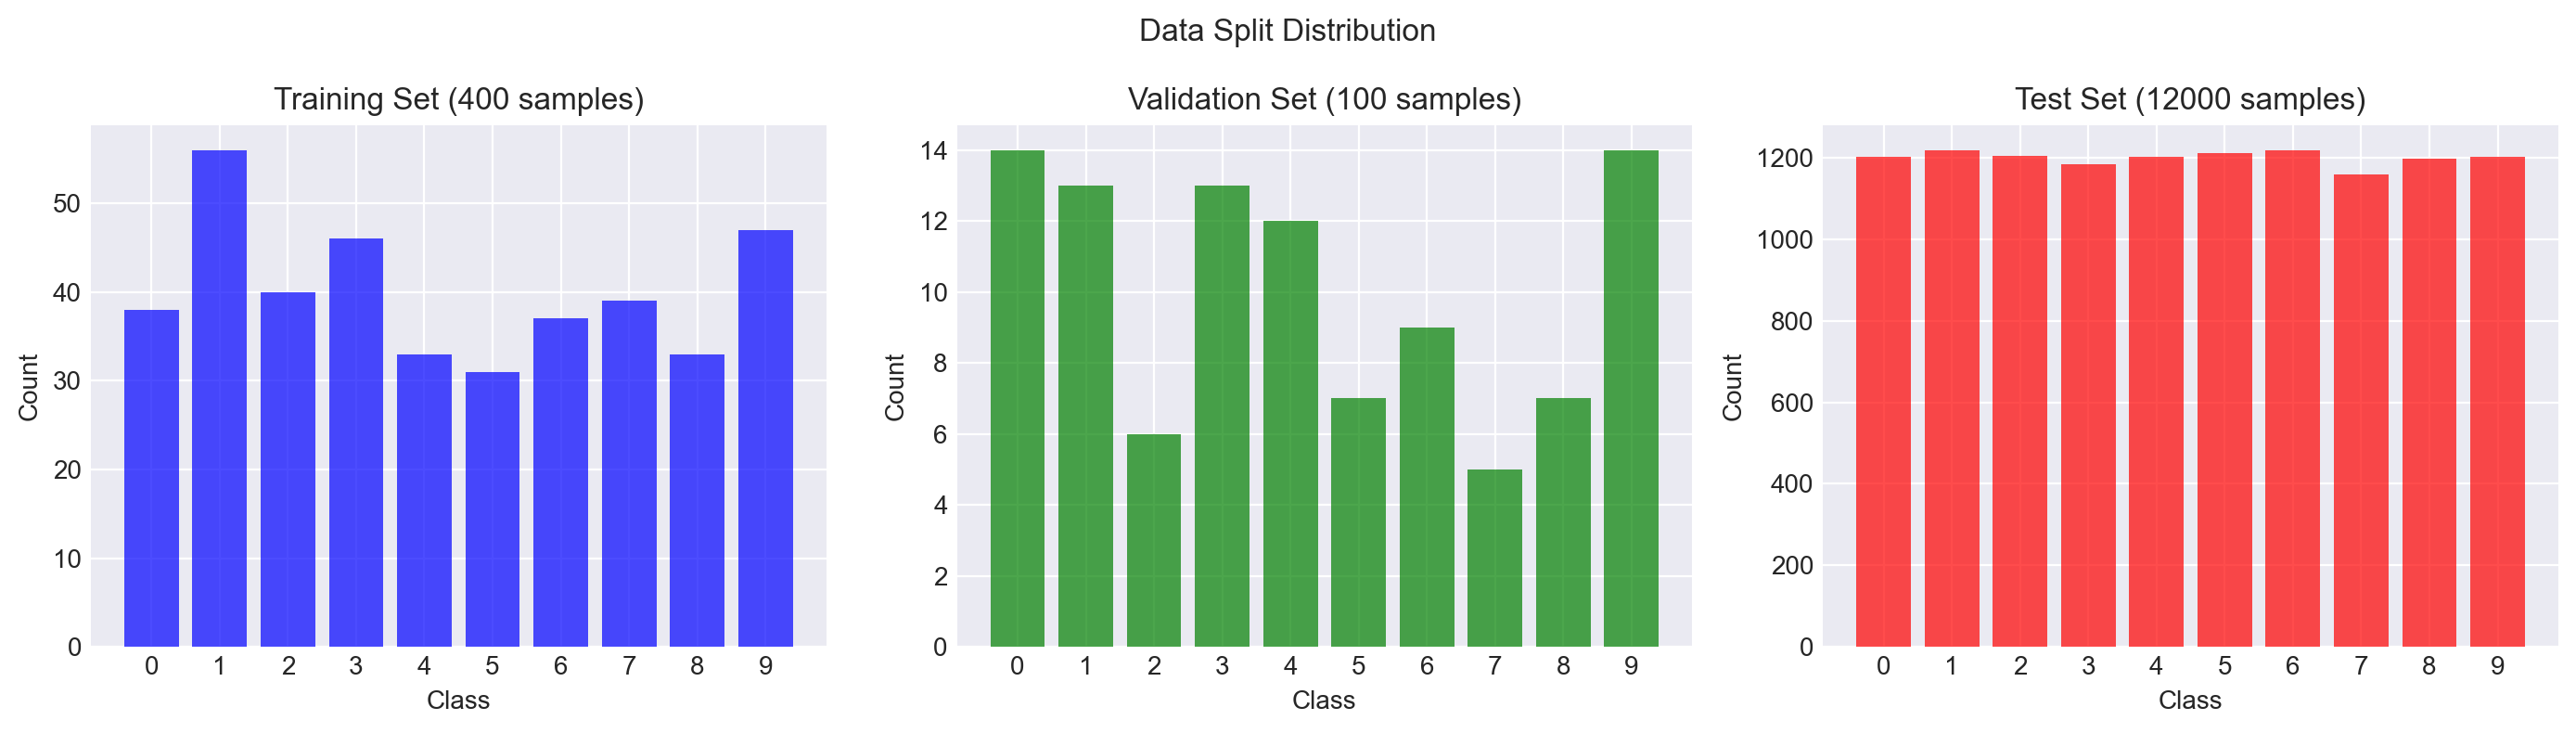

In [20]:
# Create train/val/test splits
X_temp, X_test_final, y_temp, y_test_final = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42
)
X_train_proper, X_val, y_train_proper, y_val = train_test_split(
    X_temp[:500], y_temp[:500], test_size=0.2, random_state=42  # Still using limited data
)

# Visualize the splits
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for idx, (data, label, title) in enumerate([
    (X_train_proper, y_train_proper, f'Training Set ({len(X_train_proper)} samples)'),
    (X_val, y_val, f'Validation Set ({len(X_val)} samples)'),
    (X_test_final, y_test_final, f'Test Set ({len(X_test_final)} samples)')
]):
    ax = axes[idx]
    # Show class distribution
    unique, counts = np.unique(label, return_counts=True)
    ax.bar(unique, counts, color=['blue', 'green', 'red'][idx], alpha=0.7)
    ax.set_xlabel('Class')
    ax.set_ylabel('Count')
    ax.set_title(title)
    ax.set_xticks(range(10))

plt.suptitle('Data Split Distribution')
plt.tight_layout()
plt.show()

### Learning Curves: The Diagnostic Tool

Learning curves show how performance evolves with training time or data size. They're essential for diagnosing bias vs variance problems.

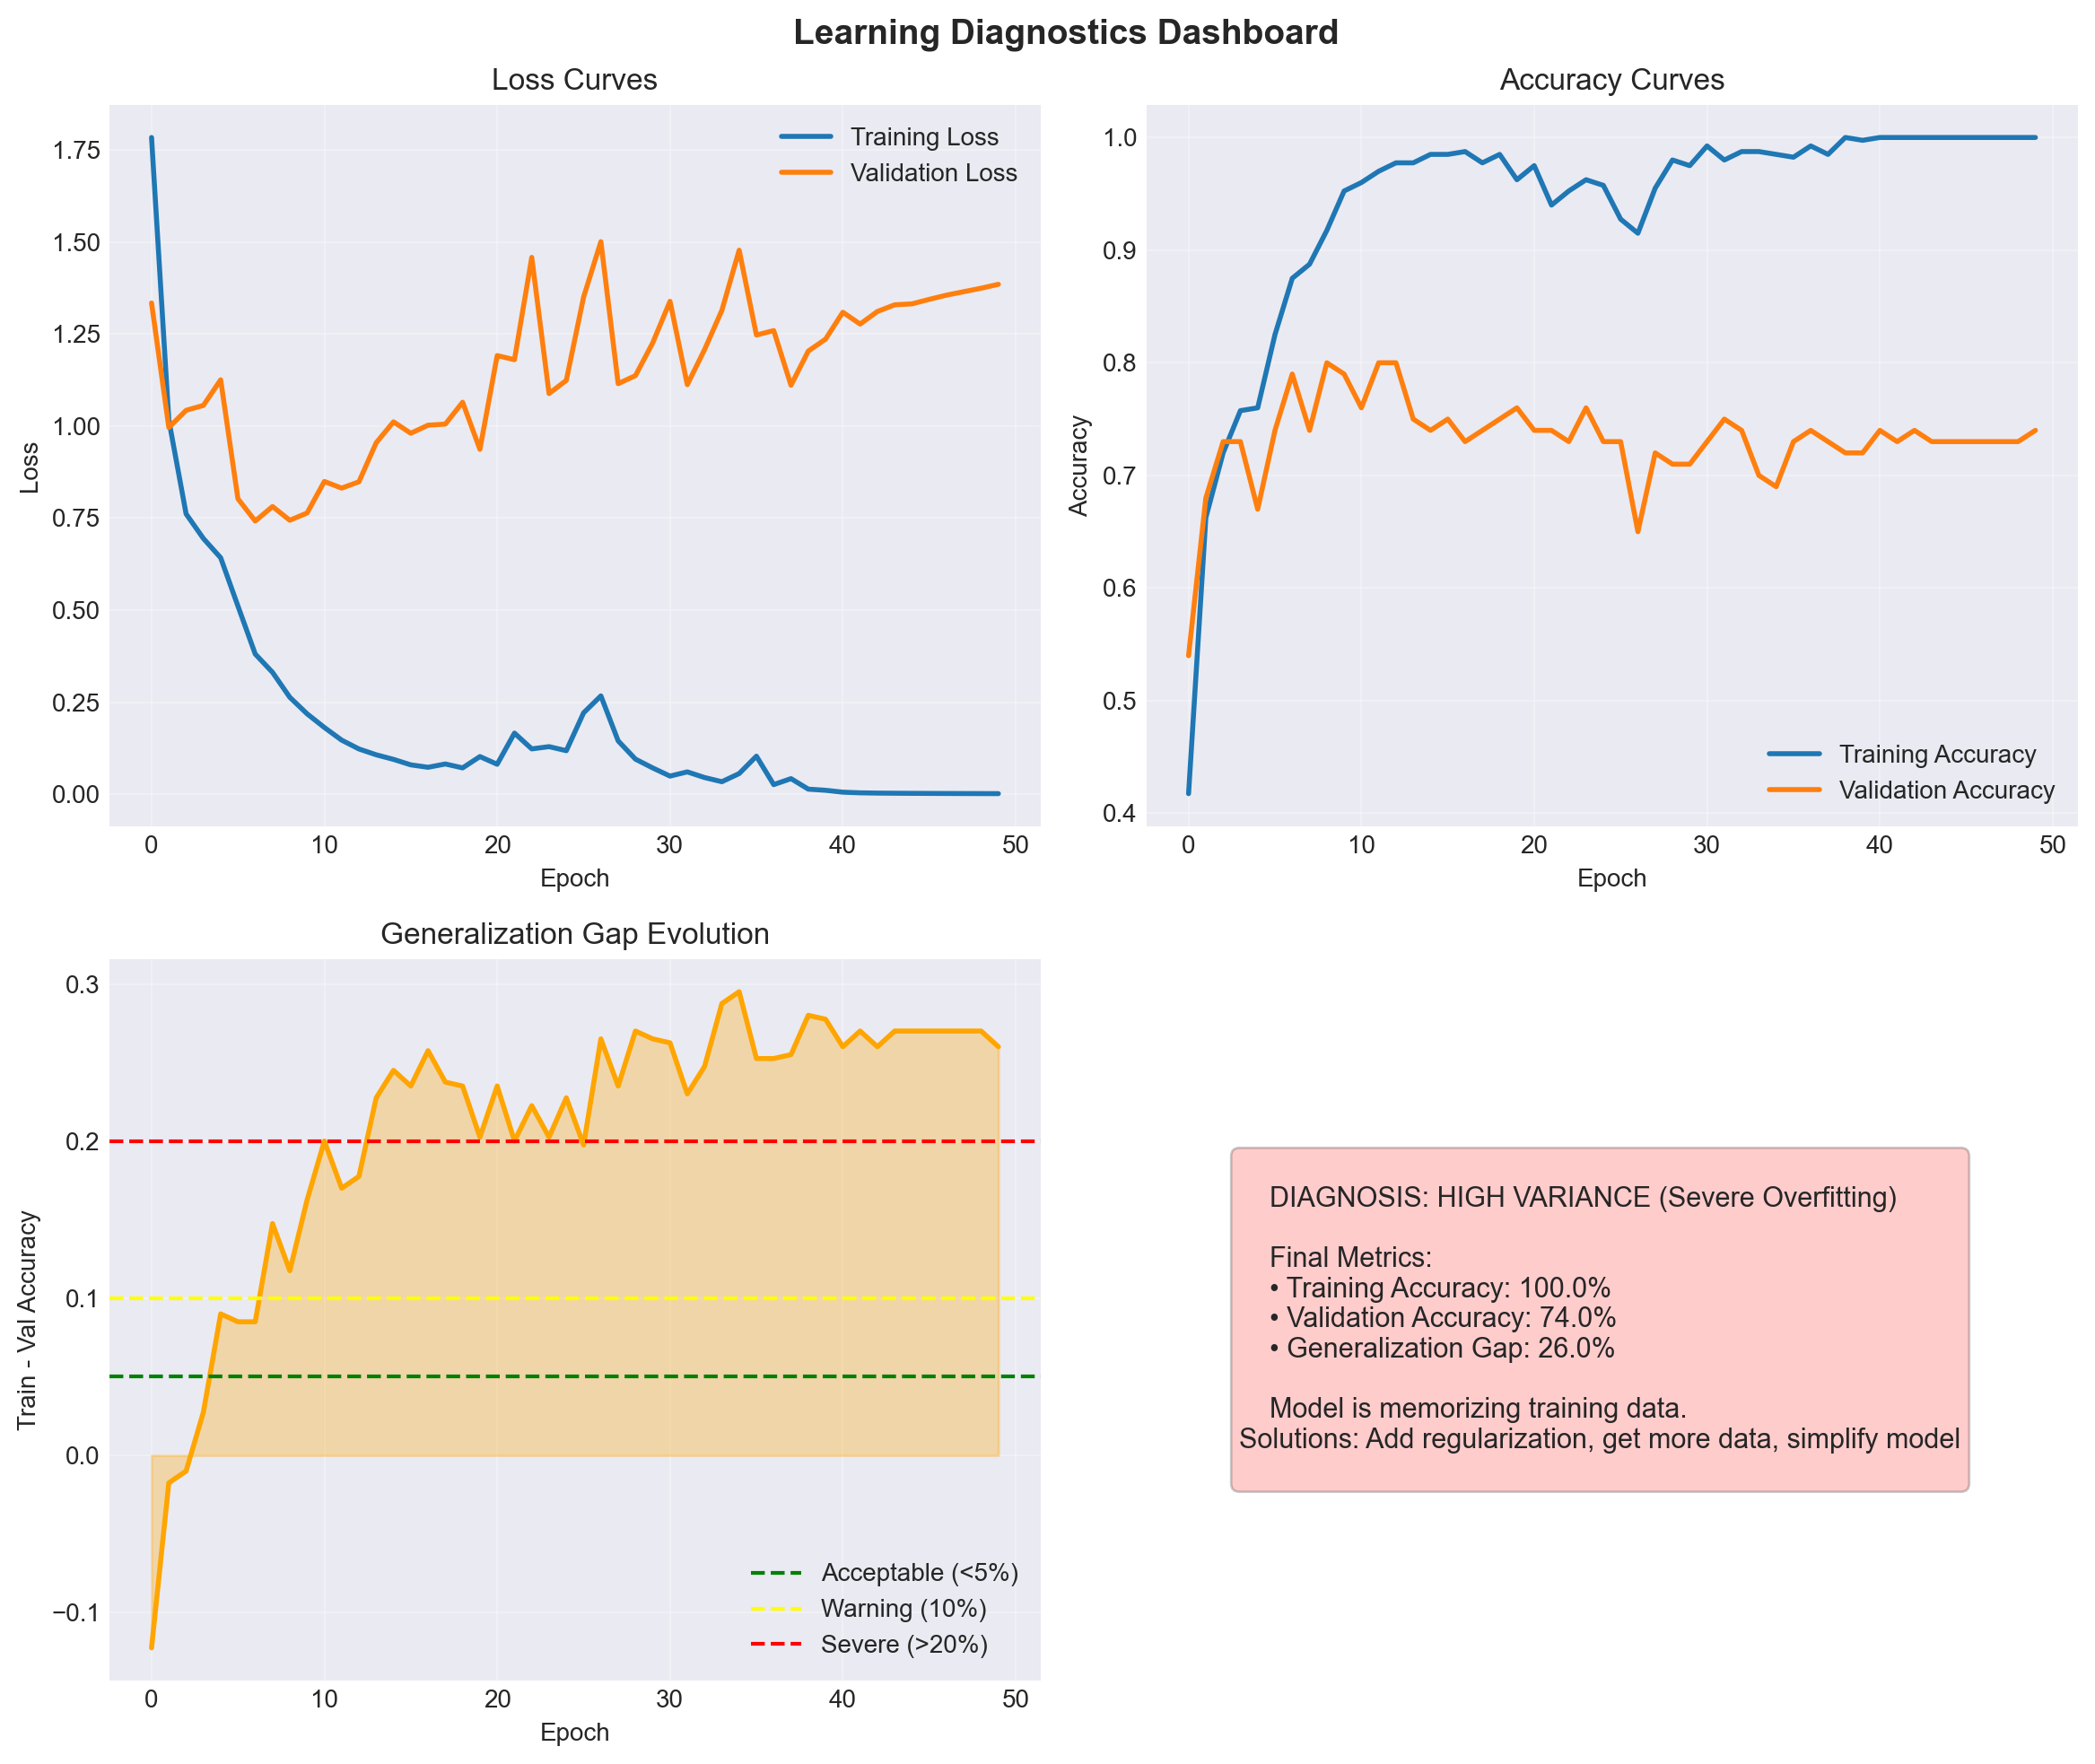

In [21]:
def plot_learning_diagnostics(model, X_train, y_train, X_val, y_val):
    """Generate comprehensive learning diagnostics"""
    
    # Train model and track metrics
    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=50, batch_size=32, verbose=0)
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Panel 1: Loss curves
    ax = axes[0, 0]
    ax.plot(history.history['loss'], label='Training Loss', linewidth=2)
    ax.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Loss Curves')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Panel 2: Accuracy curves
    ax = axes[0, 1]
    ax.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    ax.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.set_title('Accuracy Curves')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Panel 3: Generalization gap over time
    ax = axes[1, 0]
    gap = np.array(history.history['accuracy']) - np.array(history.history['val_accuracy'])
    ax.plot(gap, linewidth=2, color='orange')
    ax.fill_between(range(len(gap)), 0, gap, alpha=0.3, color='orange')
    ax.axhline(y=0.05, color='green', linestyle='--', label='Acceptable (<5%)')
    ax.axhline(y=0.1, color='yellow', linestyle='--', label='Warning (10%)')
    ax.axhline(y=0.2, color='red', linestyle='--', label='Severe (>20%)')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Train - Val Accuracy')
    ax.set_title('Generalization Gap Evolution')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Panel 4: Diagnosis
    ax = axes[1, 1]
    ax.axis('off')
    
    final_gap = gap[-1]
    final_val_acc = history.history['val_accuracy'][-1]
    
    if final_gap > 0.2:
        diagnosis = "HIGH VARIANCE (Severe Overfitting)"
        color = 'red'
        recommendation = "Model is memorizing training data.\nSolutions: Add regularization, get more data, simplify model"
    elif final_gap > 0.1:
        diagnosis = "MODERATE OVERFITTING"
        color = 'orange'
        recommendation = "Model is starting to overfit.\nSolutions: Add mild regularization, early stopping"
    elif final_val_acc < 0.6:
        diagnosis = "HIGH BIAS (Underfitting)"
        color = 'blue'
        recommendation = "Model is too simple.\nSolutions: Increase model capacity, add features"
    else:
        diagnosis = "GOOD FIT"
        color = 'green'
        recommendation = "Model is well-balanced.\nConsider fine-tuning for marginal gains"
    
    diagnosis_text = f"""
    DIAGNOSIS: {diagnosis}
    
    Final Metrics:
    • Training Accuracy: {history.history['accuracy'][-1]:.1%}
    • Validation Accuracy: {final_val_acc:.1%}
    • Generalization Gap: {final_gap:.1%}
    
    {recommendation}
    """
    
    ax.text(0.1, 0.5, diagnosis_text, transform=ax.transAxes,
           fontsize=11, verticalalignment='center',
           bbox=dict(boxstyle='round', facecolor=color, alpha=0.2))
    
    plt.suptitle('Learning Diagnostics Dashboard', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return history

# Diagnose our model
test_model = create_model()
history = plot_learning_diagnostics(test_model, X_train_proper, y_train_proper, X_val, y_val)

**Key Insight:** The diverging curves clearly show overfitting starting around epoch 10. The validation accuracy plateaus while training accuracy keeps improving - classic overfitting signature. With proper validation monitoring, we could have stopped training early.

### Cross-Validation for Robust Estimates

Single train/validation splits can be noisy. Cross-validation gives more reliable performance estimates by using multiple splits.

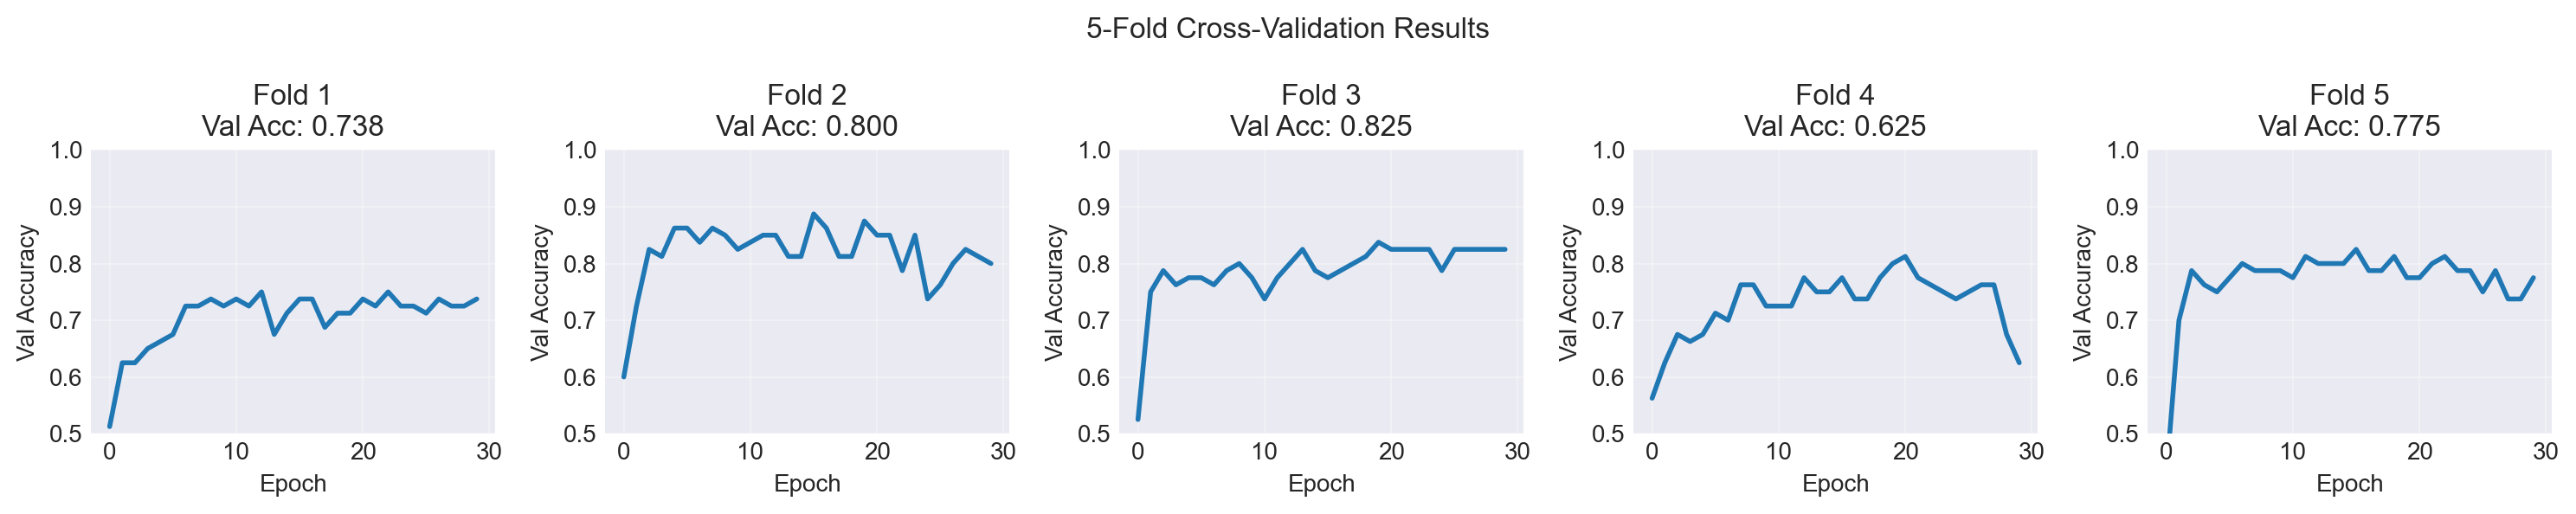

In [22]:
def cross_validate_model(model_fn, X, y, cv_folds=5):
    """Perform k-fold cross-validation and visualize results"""
    
    kfold = KFold(n_splits=cv_folds, shuffle=True, random_state=42)
    cv_scores = []
    fold_histories = []
    
    fig, axes = plt.subplots(1, cv_folds, figsize=(15, 3))
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X)):
        X_fold_train, X_fold_val = X[train_idx], X[val_idx]
        y_fold_train, y_fold_val = y[train_idx], y[val_idx]
        
        # Train model
        model = model_fn()
        history = model.fit(X_fold_train, y_fold_train,
                          validation_data=(X_fold_val, y_fold_val),
                          epochs=30, batch_size=32, verbose=0)
        
        # Record score
        score = model.evaluate(X_fold_val, y_fold_val, verbose=0)[1]
        cv_scores.append(score)
        
        # Plot this fold's learning curve
        ax = axes[fold]
        ax.plot(history.history['val_accuracy'], linewidth=2)
        ax.set_title(f'Fold {fold+1}\nVal Acc: {score:.3f}')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Val Accuracy')
        ax.set_ylim([0.5, 1.0])
        ax.grid(True, alpha=0.3)
    
    plt.suptitle(f'{cv_folds}-Fold Cross-Validation Results', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    mean_score = np.mean(cv_scores)
    std_score = np.std(cv_scores)
    
    return mean_score, std_score, cv_scores

# Run cross-validation
mean_cv, std_cv, all_scores = cross_validate_model(create_model, X_train_proper, y_train_proper)

In [91]:
print(f"Mean ± SD: {mean_cv:.3f} ± {std_cv:.3f}  "
          f"({mean_cv:.2%} ± {std_cv:.2%})")
print(f"Min/Max: {np.min(all_scores):.3f} / {np.max(all_scores):.3f}")

Mean ± SD: 0.752 ± 0.070  (75.25% ± 7.00%)
Min/Max: 0.625 / 0.825


**Cross-Validation Summary:** The model's performance varies across folds, showing the importance of multiple evaluation runs. The high standard deviation indicates unstable learning - another sign of overfitting.

## Part 2: Model-Centric and Data-Centric Views of Generalization

While regularization modifies the model, we can also improve generalization by changing the data. Let's explore three fundamental relationships using real experiments.

### Experiment 1: The Classic Model Complexity Curve

First, let's generate the classic U-shaped validation error curve by varying model complexity while keeping data fixed.


In [25]:
import tensorflow as tf
tf.keras.utils.set_random_seed(42)

# Robust single normalization
Xf = X_train_full.astype('float32')
yf = y_train_full.astype('int32')

mx = float(Xf.max())
if mx <= 0.01:         # already divided twice -> scale back
    Xf = Xf * 255.0
elif mx > 1.5:         # raw uint8 -> divide once
    Xf = Xf / 255.0

print("After fix, X max (should be ~1.0):", float(Xf.max()))

# Small train (to reveal overfitting), larger val (stable)
# Use fewer train points and more val points
X_complexity_train = Xf[:200]
y_complexity_train = yf[:200]
X_complexity_val   = Xf[200:5200]
y_complexity_val   = yf[200:5200]

# Train a bit longer with smaller batches
EPOCHS = 120
BATCH = 32

def create_model_with_hidden_units(hidden_units):
    return tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(hidden_units, activation='relu', kernel_initializer='he_normal'),
        tf.keras.layers.Dense(10, activation='softmax')
    ], name=f"mlp_{hidden_units}")

def compile_model(m):
    m.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    return m

hidden_units_list = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
# If 2048 is too slow, you can drop it later.
complexity_results = {}

print("Training models with varying complexity...")
for hidden_units in hidden_units_list:
    tf.keras.backend.clear_session()  # isolate each run
    model = compile_model(create_model_with_hidden_units(hidden_units))
    total_params = model.count_params()

    history = model.fit(
        X_complexity_train, y_complexity_train,
        validation_data=(X_complexity_val, y_complexity_val),
        epochs=EPOCHS, batch_size=BATCH, verbose=0, shuffle=True
    )
    tr_loss, tr_acc = model.evaluate(X_complexity_train, y_complexity_train, verbose=0)
    va_loss, va_acc = model.evaluate(X_complexity_val,   y_complexity_val,   verbose=0)

    complexity_results[hidden_units] = {
        'params': total_params,
        'train_loss': tr_loss, 'train_acc': tr_acc,
        'val_loss': va_loss,   'val_acc': va_acc,
        'history': history.history
    }
    print(f"Hidden units: {hidden_units:4d} | Params: {total_params:7d} | "
          f"Train: {tr_acc:.3f} | Val: {va_acc:.3f}")


After fix, X max (should be ~1.0): 1.0
Training models with varying complexity...
Hidden units:    2 | Params:    1600 | Train: 0.120 | Val: 0.090
Hidden units:    4 | Params:    3190 | Train: 0.910 | Val: 0.703
Hidden units:    8 | Params:    6370 | Train: 0.995 | Val: 0.731
Hidden units:   16 | Params:   12730 | Train: 1.000 | Val: 0.763
Hidden units:   32 | Params:   25450 | Train: 1.000 | Val: 0.755
Hidden units:   64 | Params:   50890 | Train: 1.000 | Val: 0.764
Hidden units:  128 | Params:  101770 | Train: 1.000 | Val: 0.767
Hidden units:  256 | Params:  203530 | Train: 1.000 | Val: 0.765
Hidden units:  512 | Params:  407050 | Train: 1.000 | Val: 0.770
Hidden units: 1024 | Params:  814090 | Train: 1.000 | Val: 0.775


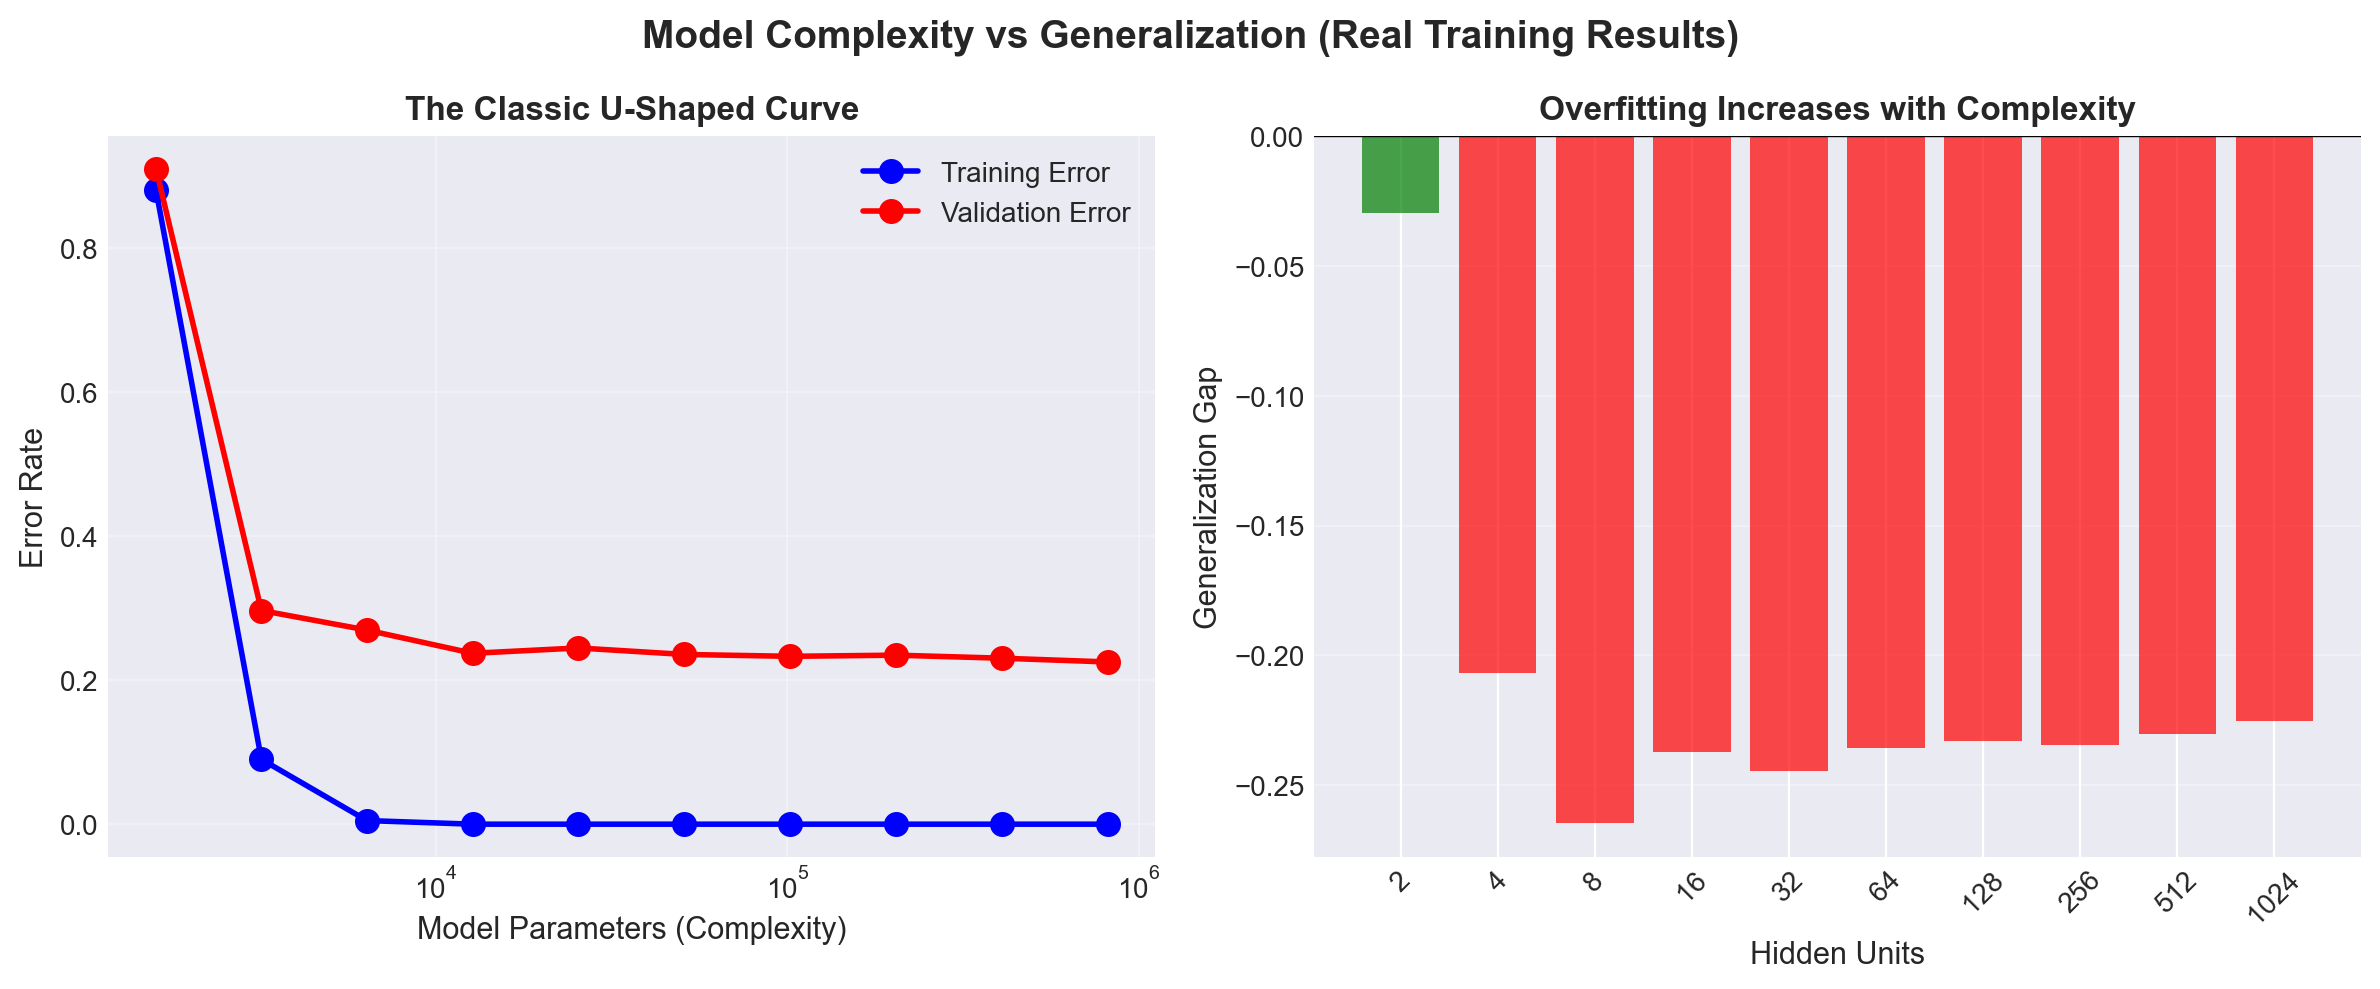

In [26]:
# Plotting (2 panels: error curves + generalization gap)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

complexities = list(complexity_results.keys())
params = [complexity_results[h]['params'] for h in complexities]
train_errors = [1 - complexity_results[h]['train_acc'] for h in complexities]
val_errors   = [1 - complexity_results[h]['val_acc']   for h in complexities]

# Panel 1: Classic error curves
ax = axes[0]
ax.plot(params, train_errors, 'o-', label='Training Error', linewidth=2, markersize=8, color='blue')
ax.plot(params, val_errors,   'o-', label='Validation Error', linewidth=2, markersize=8, color='red')
ax.set_xlabel('Model Parameters (Complexity)', fontsize=11)
ax.set_ylabel('Error Rate', fontsize=11)
ax.set_xscale('log')
ax.set_title('The Classic U-Shaped Curve', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Panel 2: Generalization gap
ax = axes[1]
gaps = [t - v for t, v in zip(train_errors, val_errors)]
colors = ['green' if abs(g) < 0.05 else 'orange' if abs(g) < 0.1 else 'red' for g in gaps]
ax.bar(range(len(complexities)), gaps, color=colors, alpha=0.7)
ax.set_xlabel('Hidden Units', fontsize=11)
ax.set_ylabel('Generalization Gap', fontsize=11)
ax.set_title('Overfitting Increases with Complexity', fontweight='bold')
ax.set_xticks(range(len(complexities)))
ax.set_xticklabels(complexities, rotation=45)
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.grid(True, alpha=0.3, axis='y')

plt.suptitle('Model Complexity vs Generalization (Real Training Results)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### Experiment 2: Data Quantity - More is Better (With Limits)

Now let's fix the model architecture and vary the amount of training data to see how quantity affects generalization.

In [27]:
# Fixed model architecture
def create_fixed_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Test different data quantities
data_sizes = [100, 250, 500, 1000, 2500, 5000, 10000, 20000]
quantity_results = {}

# Fixed validation set (already normalized earlier)
X_quantity_val = X_train_full[50000:52000]
y_quantity_val = y_train_full[50000:52000]

print("Training with varying data quantities...")
for size in data_sizes:
    # Sample training data (no re-normalization)
    X_quantity_train = X_train_full[:size]
    y_quantity_train = y_train_full[:size]

    # Isolate each run
    tf.keras.backend.clear_session()
    model = create_fixed_model()

    history = model.fit(
        X_quantity_train, y_quantity_train,
        validation_data=(X_quantity_val, y_quantity_val),
        epochs=50, batch_size=32, verbose=0
    )
    
    # Evaluate
    train_loss, train_acc = model.evaluate(X_quantity_train, y_quantity_train, verbose=0)
    val_loss, val_acc = model.evaluate(X_quantity_val, y_quantity_val, verbose=0)
    
    quantity_results[size] = {
        'train_acc': train_acc,
        'val_acc': val_acc,
        'gap': train_acc - val_acc,
        'history': history
    }
    
    print(f"Samples: {size:5d} | Train: {train_acc:.3f} | Val: {val_acc:.3f} | "
          f"Gap: {train_acc - val_acc:.3f}")


Training with varying data quantities...
Samples:   100 | Train: 1.000 | Val: 0.698 | Gap: 0.302
Samples:   250 | Train: 1.000 | Val: 0.776 | Gap: 0.224
Samples:   500 | Train: 1.000 | Val: 0.799 | Gap: 0.201
Samples:  1000 | Train: 0.995 | Val: 0.809 | Gap: 0.186
Samples:  2500 | Train: 0.966 | Val: 0.828 | Gap: 0.138
Samples:  5000 | Train: 0.970 | Val: 0.845 | Gap: 0.124
Samples: 10000 | Train: 0.942 | Val: 0.832 | Gap: 0.110
Samples: 20000 | Train: 0.937 | Val: 0.855 | Gap: 0.082


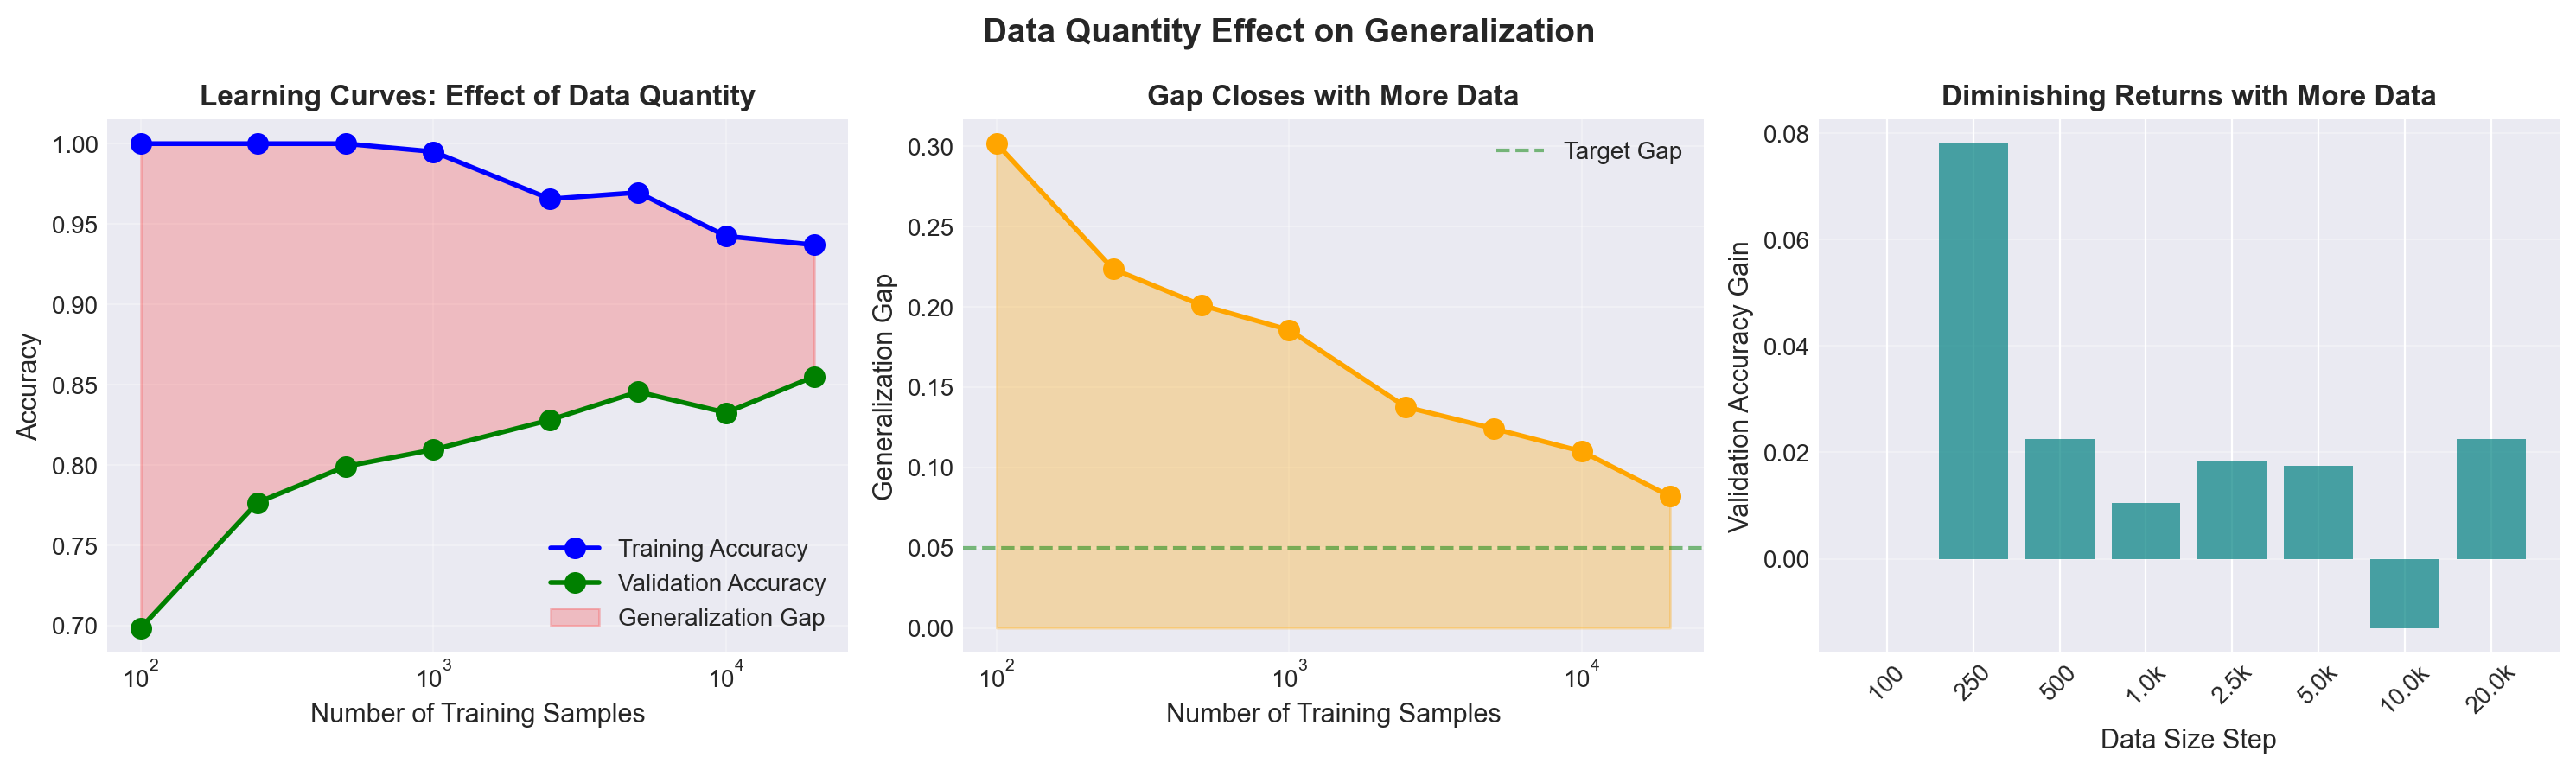

DATA QUANTITY INSIGHTS
Small Data (100–500 samples):
• Gap: 24.2%
• Large gains from adding data
Medium Data (1k–5k samples):
• Gap: 14.9%
• Still benefits from more data
Large Data (10k+ samples):
• Gap: 9.6%
• Diminishing returns

Key Finding:
- 100 -> 1000 samples: +11.1% val accuracy
- 1000 -> 20000 samples: +4.6% val accuracy


In [28]:
# Visualize data quantity effects (3 plots in one row + plain-text summary)
fig, axes = plt.subplots(1, 3, figsize=(15, 4.5))

train_accs = [quantity_results[s]['train_acc'] for s in data_sizes]
val_accs   = [quantity_results[s]['val_acc']   for s in data_sizes]
gaps       = [quantity_results[s]['gap']       for s in data_sizes]

# Panel 1: Learning curves
ax = axes[0]
ax.plot(data_sizes, train_accs, 'o-', label='Training Accuracy', linewidth=2, markersize=8, color='blue')
ax.plot(data_sizes, val_accs,   'o-', label='Validation Accuracy', linewidth=2, markersize=8, color='green')
ax.fill_between(data_sizes, val_accs, train_accs, alpha=0.2, color='red', label='Generalization Gap')
ax.set_xlabel('Number of Training Samples', fontsize=11)
ax.set_ylabel('Accuracy', fontsize=11)
ax.set_xscale('log')
ax.set_title('Learning Curves: Effect of Data Quantity', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Panel 2: Generalization gap
ax = axes[1]
ax.plot(data_sizes, gaps, 'o-', linewidth=2, markersize=8, color='orange')
ax.fill_between(data_sizes, 0, gaps, alpha=0.3, color='orange')
ax.set_xlabel('Number of Training Samples', fontsize=11)
ax.set_ylabel('Generalization Gap', fontsize=11)
ax.set_xscale('log')
ax.set_title('Gap Closes with More Data', fontweight='bold')
ax.axhline(y=0.05, color='green', linestyle='--', alpha=0.5, label='Target Gap')
ax.legend()
ax.grid(True, alpha=0.3)

# Panel 3: Diminishing returns
ax = axes[2]
improvements = [val_accs[i] - val_accs[i-1] if i > 0 else 0 for i in range(len(val_accs))]
ax.bar(range(len(data_sizes)), improvements, color='teal', alpha=0.7)
ax.set_xlabel('Data Size Step', fontsize=11)
ax.set_ylabel('Validation Accuracy Gain', fontsize=11)
ax.set_title('Diminishing Returns with More Data', fontweight='bold')
ax.set_xticks(range(len(data_sizes)))
ax.set_xticklabels([f'{s/1000:.1f}k' if s >= 1000 else str(s) for s in data_sizes], rotation=45)
ax.grid(True, alpha=0.3, axis='y')

plt.suptitle('Data Quantity Effect on Generalization', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Plain-text summary (no textbox)
small_gap = np.mean([quantity_results[s]['gap'] for s in [100, 250, 500]])
medium_gap = np.mean([quantity_results[s]['gap'] for s in [1000, 2500, 5000]])
large_gap = np.mean([quantity_results[s]['gap'] for s in [10000, 20000]])

i0 = data_sizes.index(100)
i3 = data_sizes.index(1000)
improve_0_to_3 = val_accs[i3] - val_accs[i0]
improve_3_to_last = val_accs[-1] - val_accs[i3]

print("DATA QUANTITY INSIGHTS")
print("=====================")
print("Small Data (100–500 samples):")
print(f"• Gap: {small_gap:.1%}")
print("• Large gains from adding data")
print("Medium Data (1k–5k samples):")
print(f"• Gap: {medium_gap:.1%}")
print("• Still benefits from more data")
print("Large Data (10k+ samples):")
print(f"• Gap: {large_gap:.1%}")
print("• Diminishing returns")
print()
print(f"Key Finding:")
print(f"- {data_sizes[i0]} -> {data_sizes[i3]} samples: +{improve_0_to_3:.1%} val accuracy")
print(f"- {data_sizes[i3]} -> {data_sizes[-1]} samples: +{improve_3_to_last:.1%} val accuracy")

### Experiment 3: Data Diversity - Quality Over Quantity

Finally, let's show that diversity matters more than quantity for out-of-distribution generalization.

#### Diversity measures

- Coverage (0–1): the fraction of labels present in the training set.
  
  Let C be the number of classes (C=10), n_c the count of class c, and 1[·] the indicator.
  $$
  \text{Coverage} \;=\; \frac{1}{C}\sum_{c=1}^{C} \mathbf{1}[\,n_c>0\,].
  $$

- Normalized Shannon entropy (0–1): measures how evenly examples are distributed across classes.
  
  With total N = ∑_c n_c and class proportions p_c = n_c / N,
  $$
  H_{\text{norm}} \;=\; -\frac{1}{\log C}\sum_{c=1}^{C} p_c \log p_c,
  $$
  where log is the natural logarithm. This normalization makes
  $H_{\text{norm}}=0$ when all data are in one class and $H_{\text{norm}}=1$ when the data are perfectly balanced across all C classes.

Why it matters: With a fixed data budget, including more classes (higher coverage/entropy) tends to improve overall and OOD robustness, even though each class gets fewer examples.

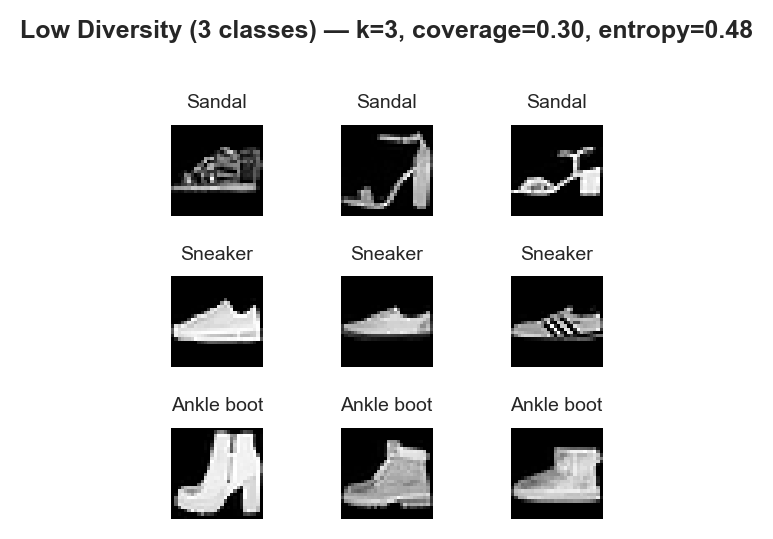

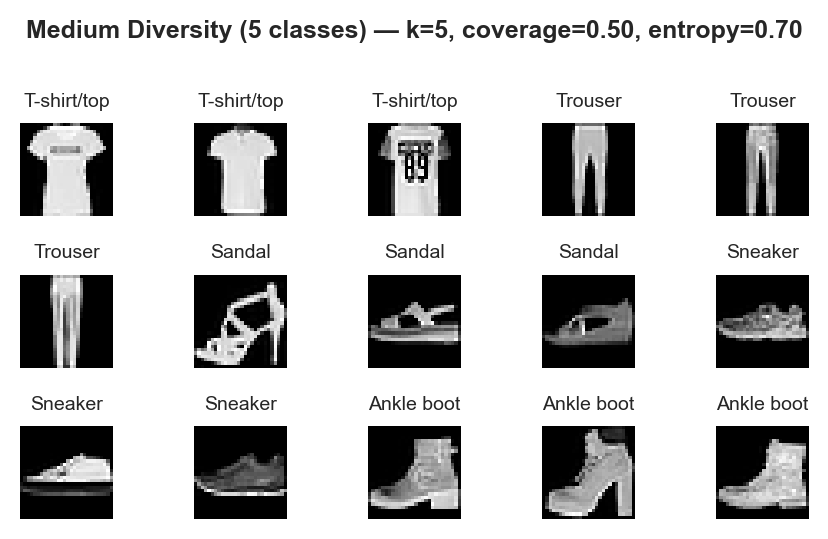

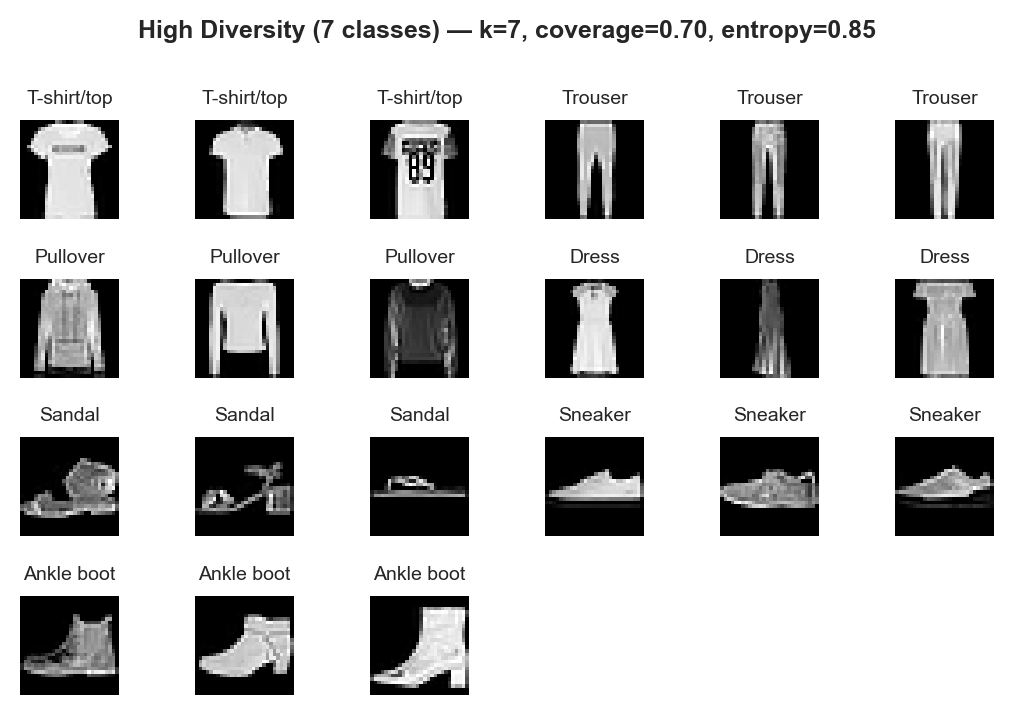

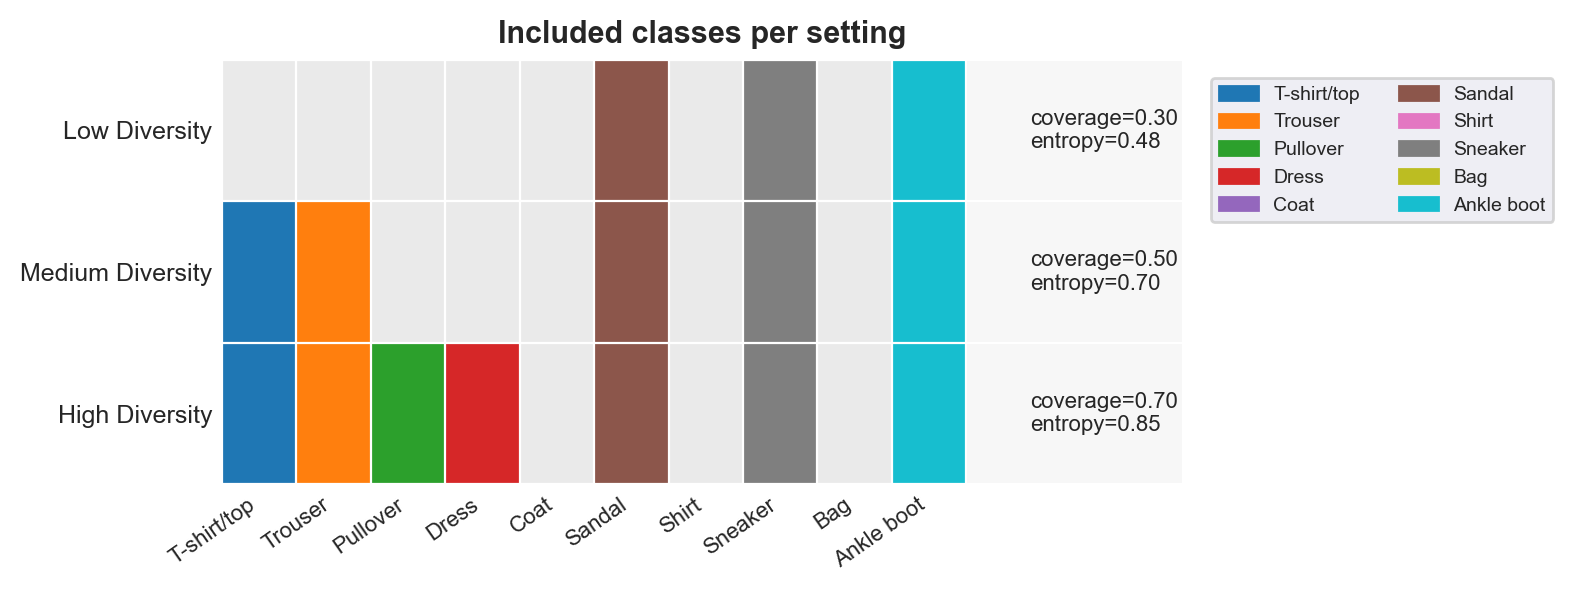

Low Diversity: k=3 | coverage=0.30 | entropy=0.48
Medium Diversity: k=5 | coverage=0.50 | entropy=0.70
High Diversity: k=7 | coverage=0.70 | entropy=0.85


In [29]:
# Visual examples of "diversity": which classes are included (smaller, with measures)
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Define three diversity settings by class labels (0..9)
low_div_classes    = [5, 7, 9]               # footwear
medium_div_classes = [0, 1, 5, 7, 9]         # mixed
high_div_classes   = [0, 1, 2, 3, 5, 7, 9]   # varied

class_names = ['T-shirt/top','Trouser','Pullover','Dress','Coat',
               'Sandal','Shirt','Sneaker','Bag','Ankle boot']

def diversity_measures_for_classes(classes, C=10):
    # Assume uniform mix over the selected classes (good illustration)
    k = len(classes)
    coverage = k / C
    H_norm = 0.0 if k == 0 else (np.log(k) / np.log(C))  # normalized Shannon entropy
    return coverage, float(H_norm)

def plot_class_examples(X, y, classes, n_per_class=3, title=""):
    # Pick n_per_class examples per class
    imgs, labels = [], []
    rng = np.random.default_rng(42)
    for c in classes:
        idx = np.where(y == c)[0]
        pick = rng.choice(idx, size=min(n_per_class, len(idx)), replace=False)
        imgs.extend(X[pick])
        labels.extend([c]*len(pick))

    n = len(imgs)
    cols = min(6, max(len(classes), 3))       # narrower grid for notebooks
    rows = int(np.ceil(n / cols))
    cell = 0.9                                # inches per cell (smaller)
    plt.figure(figsize=(cell*cols, cell*rows))

    for i, (im, lab) in enumerate(zip(imgs, labels), 1):
        ax = plt.subplot(rows, cols, i)
        ax.imshow(im, cmap='gray', interpolation='nearest')
        ax.set_title(class_names[lab], fontsize=7)
        ax.axis('off')

    cov, H = diversity_measures_for_classes(classes)
    plt.suptitle(f"{title} — k={len(classes)}, coverage={cov:.2f}, entropy={H:.2f}",
                 fontsize=9, fontweight='bold')
    plt.tight_layout()
    plt.show()

def plot_coverage_bar(classes_sets, titles):
    """
    Inclusion matrix:
    - Each column is a class, colored with tab10 if included, gray if excluded.
    - Coverage and entropy are annotated per row.
    - Major grid is disabled so each class appears as a single column.
    """
    rows = len(classes_sets)
    C = 10

    # Per-class colors (consistent, high-contrast)
    class_colors = np.array(plt.cm.tab10(np.linspace(0, 1, C)))[:, :3]
    off_color = np.array([0.92, 0.92, 0.92])  # light gray for excluded

    # Build RGB image (rows x classes x 3)
    rgb = np.tile(off_color, (rows, C, 1))
    cov_vals, H_vals = [], []
    for r, cls in enumerate(classes_sets):
        k = len(cls)
        coverage = k / C
        H_norm = 0.0 if k == 0 else (np.log(k) / np.log(C))
        cov_vals.append(coverage); H_vals.append(H_norm)
        for c in cls:
            rgb[r, c, :] = class_colors[c]

    # Plot
    fig, ax = plt.subplots(figsize=(8.0, 2.0 + 0.35*rows))
    ax.set_facecolor((0.97, 0.97, 0.97))
    ax.imshow(rgb, aspect='auto', interpolation='nearest')
    ax.set_title("Included classes per setting", fontsize=11, fontweight='bold')

    # Ticks/labels
    ax.set_yticks(range(rows))
    ax.set_yticklabels(titles, fontsize=9)
    ax.set_xticks(range(C))
    ax.set_xticklabels(class_names, rotation=35, ha='right', fontsize=8)

    # Disable major grid from seaborn style to avoid “two columns” effect
    ax.grid(False)

    # Draw only cell boundaries as minor grid
    ax.set_xticks(np.arange(-0.5, C, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, rows, 1), minor=True)
    ax.grid(which='minor', color='white', linewidth=0.8)
    ax.tick_params(which='minor', bottom=False, left=False)

    # Annotate measures on the right margin
    ax.set_xlim(-0.5, C + 2.4)
    for r, (cov, H) in enumerate(zip(cov_vals, H_vals)):
        ax.text(C + 0.35, r, f"coverage={cov:.2f}\nentropy={H:.2f}",
                va='center', fontsize=8)

    # Compact legend (optional)
    from matplotlib.patches import Patch
    legend_patches = [Patch(color=class_colors[i], label=class_names[i]) for i in range(C)]
    ax.legend(handles=legend_patches, ncol=2, fontsize=7, frameon=True,
              loc='upper left', bbox_to_anchor=(1.02, 0.98))

    plt.tight_layout()
    plt.show()

# 1) Show example images for each diversity setting (smaller)
plot_class_examples(X_train_full, y_train_full, low_div_classes,    n_per_class=3,
                    title="Low Diversity (3 classes)")
plot_class_examples(X_train_full, y_train_full, medium_div_classes, n_per_class=3,
                    title="Medium Diversity (5 classes)")
plot_class_examples(X_train_full, y_train_full, high_div_classes,   n_per_class=3,
                    title="High Diversity (7 classes)")

# 2) Inclusion matrix with measures shown
plot_coverage_bar(
    [low_div_classes, medium_div_classes, high_div_classes],
    ["Low Diversity", "Medium Diversity", "High Diversity"]
)

# 3) Also print the measures plainly
for name, cls in [("Low", low_div_classes), ("Medium", medium_div_classes), ("High", high_div_classes)]:
    cov, H = diversity_measures_for_classes(cls)
    print(f"{name} Diversity: k={len(cls)} | coverage={cov:.2f} | entropy={H:.2f}")

Training with fixed total samples across diversity settings...
1 class              | Train: 1.000 | In-Dist: 1.000 | OOD_shift: 0.100 | OOD_unseen: 0.000 | Overall(10-way): 0.100
2 classes            | Train: 0.994 | In-Dist: 0.983 | OOD_shift: 0.148 | OOD_unseen: 0.000 | Overall(10-way): 0.197
3 classes            | Train: 0.984 | In-Dist: 0.966 | OOD_shift: 0.287 | OOD_unseen: 0.000 | Overall(10-way): 0.290
5 classes            | Train: 0.786 | In-Dist: 0.749 | OOD_shift: 0.361 | OOD_unseen: 0.000 | Overall(10-way): 0.375
7 classes            | Train: 0.800 | In-Dist: 0.758 | OOD_shift: 0.525 | OOD_unseen: 0.000 | Overall(10-way): 0.531
10 classes           | Train: 0.727 | In-Dist: 0.662 | OOD_shift: 0.589 | OOD_unseen: nan | Overall(10-way): 0.662


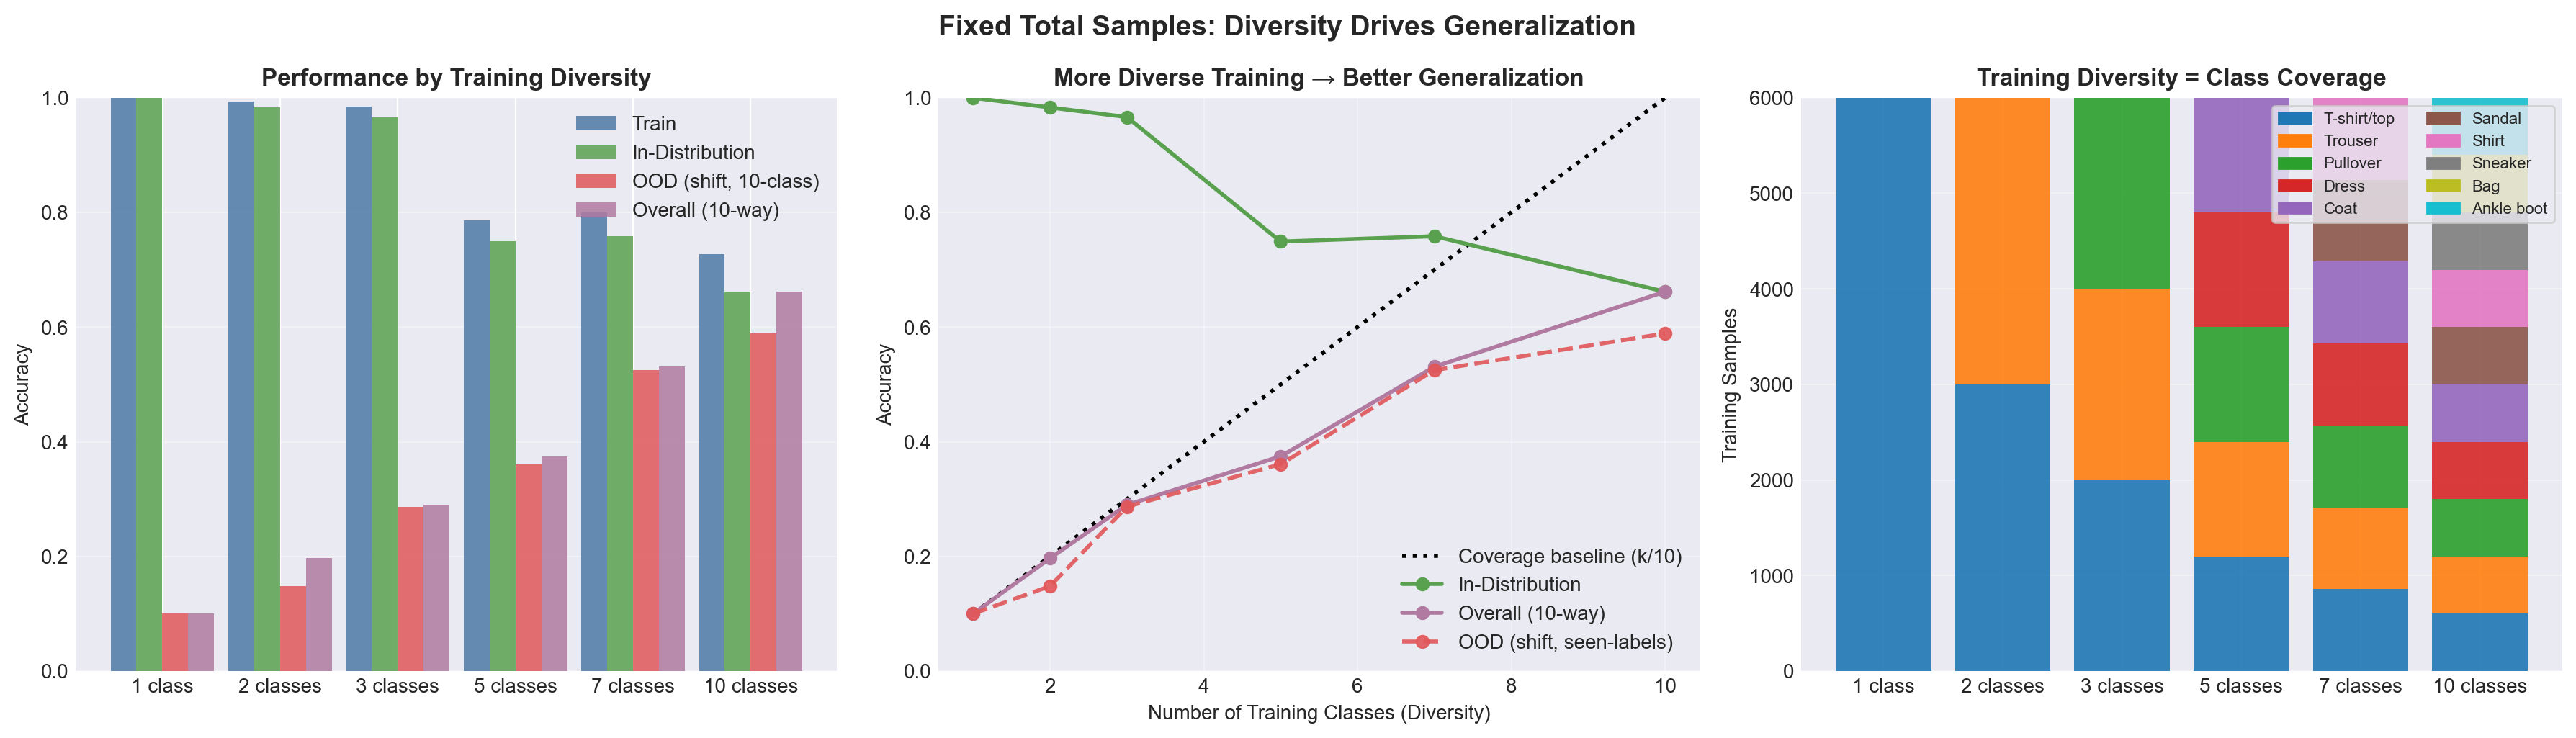


Summary (fixed total samples):
- 1 class            | Classes: 1 | Overall: 0.100 | ID: 1.000 | OOD_shift: 0.100 | Excess over coverage: +0.000 | OOD_unseen: 0.000
- 2 classes          | Classes: 2 | Overall: 0.197 | ID: 0.983 | OOD_shift: 0.148 | Excess over coverage: -0.052 | OOD_unseen: 0.000
- 3 classes          | Classes: 3 | Overall: 0.290 | ID: 0.966 | OOD_shift: 0.287 | Excess over coverage: -0.013 | OOD_unseen: 0.000
- 5 classes          | Classes: 5 | Overall: 0.375 | ID: 0.749 | OOD_shift: 0.361 | Excess over coverage: -0.139 | OOD_unseen: 0.000
- 7 classes          | Classes: 7 | Overall: 0.531 | ID: 0.758 | OOD_shift: 0.525 | Excess over coverage: -0.175 | OOD_unseen: 0.000
- 10 classes         | Classes: 10 | Overall: 0.662 | ID: 0.662 | OOD_shift: 0.589 | Excess over coverage: -0.411 | OOD_unseen: nan


In [30]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

tf.keras.utils.set_random_seed(42)
np.random.seed(42)

# 1) Safety: normalize exactly once
def _ensure_single_normalization(X):
    X = X.astype('float32')
    m = float(X.max())
    if m <= 0.01:   # likely divided twice
        X = X * 255.0
    if X.max() > 1.5:  # raw 0..255
        X = X / 255.0
    return X

X_train_full = _ensure_single_normalization(X_train_full)
X_test       = _ensure_single_normalization(X_test)
y_train_full = y_train_full.astype('int32')
y_test       = y_test.astype('int32')

# 2) Helpers
def _take_per_class(X, y, classes, n_per_class):
    X_out, y_out = [], []
    for c in classes:
        m = (y == c)
        Xc, yc = X[m][:n_per_class], y[m][:n_per_class]
        if len(Xc) < n_per_class:  # pad with replacement if short
            need = n_per_class - len(Xc)
            if len(Xc) > 0:
                idx = np.random.choice(len(Xc), size=need, replace=True)
                Xc = np.concatenate([Xc, Xc[idx]], axis=0)
                yc = np.concatenate([yc, yc[idx]], axis=0)
            else:
                Xc = np.zeros((n_per_class, *X.shape[1:]), dtype=X.dtype)
                yc = np.full((n_per_class,), c, dtype=y.dtype)
        X_out.append(Xc); y_out.append(yc)
    return np.concatenate(X_out), np.concatenate(y_out)

def _filter_classes(X, y, classes):
    if len(classes) == 0:
        return np.empty((0, *X.shape[1:]), dtype=X.dtype), np.empty((0,), dtype=y.dtype)
    m = np.isin(y, classes)
    return X[m], y[m]

def prepare_diversity_data_fixed_total(train_categories, test_categories,
                                       target_total=3600, n_id_total=300, n_ood_total=300):
    """Balanced sampling so total train examples ~= target_total."""
    per_class = max(1, target_total // max(1, len(train_categories)))
    X_tr, y_tr = _take_per_class(X_train_full, y_train_full, train_categories, per_class)

    n_id_per = max(1, n_id_total // max(1, len(train_categories)))
    X_id, y_id = _take_per_class(X_test, y_test, train_categories, n_id_per)

    if len(test_categories) > 0:
        n_ood_per = max(1, n_ood_total // len(test_categories))
        X_ood, y_ood = _take_per_class(X_test, y_test, test_categories, n_ood_per)
    else:
        X_ood = np.empty((0, *X_test.shape[1:]), dtype=X_test.dtype)
        y_ood = np.empty((0,), dtype=y_test.dtype)

    return X_tr, y_tr, X_id, y_id, X_ood, y_ood

# # Stronger, randomized distribution shift on [0,1] data (brightness + contrast + noise)
# def make_ood_shift(X, brightness=(0.20, 0.40), contrast=(0.20, 0.60), noise_std=0.08, rng=42):
#     r = np.random.default_rng(rng)
#     b = r.uniform(*brightness)
#     c = r.uniform(*contrast)
#     Xc = (X - 0.5) * (1.0 + c) + 0.5 + b
#     Xn = Xc + r.normal(0.0, noise_std, size=X.shape).astype('float32')
#     return np.clip(Xn, 0.0, 1.0)

def make_ood_shift(X, brightness=(0.20, 0.40), contrast=(0.20, 0.60), noise_std=0.08, rng=42):
    """
    Per-image random brightness/contrast + noise on X in [0,1].
    Produces a clearer OOD gap while preserving the increasing trend.
    """
    r = np.random.default_rng(rng)
    N = len(X)
    b = r.uniform(brightness[0], brightness[1], size=(N, 1, 1))
    c = r.uniform(contrast[0], contrast[1],  size=(N, 1, 1))
    Xc = (X - 0.5) * (1.0 + c) + 0.5 + b
    Xn = Xc + r.normal(0.0, noise_std, size=X.shape).astype('float32')
    return np.clip(Xn, 0.0, 1.0)
    
def build_model_10():
    m = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    m.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return m

# 3) Experiments (nested class sets -> monotonic coverage)
ordered_classes = [0,1,2,3,4,5,6,7,8,9]
levels = [1, 2, 3, 5, 7, 10]
diversity_experiments = {
    f"{k} class{'es' if k>1 else ''}": {'train': ordered_classes[:k]}
    for k in levels
}

TARGET_TOTAL = 6000

diversity_results = {}
class_counts = []

print("Training with fixed total samples across diversity settings...")
for name, cfg in diversity_experiments.items():
    train_classes = cfg['train']

    # Ensure we never overshoot available data for any selected class
    per_class_avail = min(np.sum(y_train_full == c) for c in train_classes)
    effective_total = min(TARGET_TOTAL, per_class_avail * len(train_classes))
    
    X_tr, y_tr, X_id_bal, y_id_bal, _, _ = prepare_diversity_data_fixed_total(
        train_classes, [], target_total=effective_total, n_id_total=500, n_ood_total=0
    )
    # Train set (balanced per seen class)
    # X_tr, y_tr, X_id_bal, y_id_bal, _, _ = prepare_diversity_data_fixed_total(
    #     train_classes, [], target_total=TARGET_TOTAL, n_id_total=500, n_ood_total=0
    # )

    # ID = all test examples from seen classes (lower variance)
    X_id_all, y_id_all = _filter_classes(X_test, y_test, train_classes)

    # revised: OOD_shift on ALL 10 classes (robustness curve that improves with diversity)
    rng_seed = 100 + len(train_classes)  # just to vary the shift per level
    X_ood_shift = make_ood_shift(X_test, rng=rng_seed)
    y_ood_shift = y_test
    
    # OOD_unseen (for completeness, often ~0 until labels are seen)
    unseen_classes = [c for c in range(10) if c not in train_classes]
    X_ood_unseen, y_ood_unseen = _filter_classes(X_test, y_test, unseen_classes)

    # Track coverage for the stacked bar
    counts = np.array([np.sum(y_tr == c) for c in range(10)])
    class_counts.append(counts)

    tf.keras.backend.clear_session()
    model = build_model_10()
    model.fit(X_tr, y_tr, validation_split=0.2, epochs=20, batch_size=128, verbose=0)

    train_acc      = model.evaluate(X_tr, y_tr, verbose=0)[1]
    id_acc         = model.evaluate(X_id_all, y_id_all, verbose=0)[1] if len(X_id_all) else np.nan
    ood_shift_acc  = model.evaluate(X_ood_shift, y_ood_shift, verbose=0)[1] if len(X_ood_shift) else np.nan
    ood_unseen_acc = (model.evaluate(X_ood_unseen, y_ood_unseen, verbose=0)[1]
                      if len(X_ood_unseen) else np.nan)
    overall        = model.evaluate(X_test, y_test, verbose=0)[1]

    diversity_results[name] = {
        'train_acc': train_acc,
        'id_acc': id_acc,
        'ood_shift_acc': ood_shift_acc,
        'ood_unseen_acc': ood_unseen_acc,
        'overall_acc': overall,
        'n_train_classes': len(train_classes)
    }
    coverage = len(train_classes) / 10.0
    diversity_results[name]['coverage'] = coverage
    diversity_results[name]['excess_ood'] = diversity_results[name]['ood_shift_acc'] - coverage

    print(f"{name:20s} | "
          f"Train: {train_acc:.3f} | In-Dist: {id_acc:.3f} | "
          f"OOD_shift: {ood_shift_acc:.3f} | OOD_unseen: {ood_unseen_acc:.3f} | "
          f"Overall(10-way): {overall:.3f}")

# 4) Visualization
experiments = list(diversity_results.keys())
n_classes_trained = [diversity_results[e]['n_train_classes'] for e in experiments]
train_accs  = [diversity_results[e]['train_acc']  for e in experiments]
id_accs     = [diversity_results[e]['id_acc']     for e in experiments]
ood_shift_accs = [diversity_results[e]['ood_shift_acc'] for e in experiments]
overall_acc = [diversity_results[e]['overall_acc'] for e in experiments]

fig, axes = plt.subplots(1, 3, figsize=(18, 5.2))

# Panel 1: Accuracy bars
ax = axes[0]
x = np.arange(len(experiments))
w = 0.22
ax.bar(x - 1.5*w, train_accs,     w, label='Train', alpha=0.85, color='#4e79a7')
ax.bar(x - 0.5*w, id_accs,        w, label='In-Distribution', alpha=0.85, color='#59a14f')
ax.bar(x + 0.5*w, ood_shift_accs, w, label='OOD (shift, 10-class)', alpha=0.85, color='#e15759')
ax.bar(x + 1.5*w, overall_acc,    w, label='Overall (10-way)', alpha=0.85, color='#b07aa1')
ax.set_title('Performance by Training Diversity', fontweight='bold')
ax.set_xticks(x); ax.set_xticklabels([e.replace('\\n','\n') for e in experiments])
ax.set_ylabel('Accuracy'); ax.set_ylim(0, 1.0)
ax.grid(True, axis='y', alpha=0.3); ax.legend()

# Panel 2: Line trend vs number of training classes
ax = axes[1]
order = np.argsort(n_classes_trained)
nc = np.array(n_classes_trained)[order]
coverage_line = [diversity_results[e]['coverage'] for e in experiments]
ax.plot(nc, np.array(coverage_line)[order], 'k:', label='Coverage baseline (k/10)', linewidth=2)
ax.plot(nc, np.array(id_accs)[order],          'o-', label='In-Distribution', linewidth=2, color='#59a14f')
ax.plot(nc, np.array(overall_acc)[order],      'o-', label='Overall (10-way)', linewidth=2, color='#b07aa1')
ax.plot(nc, np.array(ood_shift_accs)[order],   'o--', label='OOD (shift, seen-labels)', linewidth=2, color='#e15759', alpha=0.9)
ax.set_xlabel('Number of Training Classes (Diversity)')
ax.set_ylabel('Accuracy'); ax.set_ylim(0, 1.0)
ax.set_title('More Diverse Training → Better Generalization', fontweight='bold')
ax.grid(True, alpha=0.3); ax.legend()

# Panel 3: Class coverage (robust to empty)
ax = axes[2]
if len(class_counts) == 0:
    raise RuntimeError("class_counts is empty; ensure counts are appended in the loop.")
class_counts_arr = np.stack(class_counts)  # [num_experiments, 10]
class_names = ['T-shirt/top','Trouser','Pullover','Dress','Coat',
               'Sandal','Shirt','Sneaker','Bag','Ankle boot']
colors = plt.cm.tab10.colors
bottom = np.zeros(len(experiments))
for c in range(10):
    ax.bar(x, class_counts_arr[:, c], bottom=bottom, color=colors[c], alpha=0.9)
    bottom += class_counts_arr[:, c]
ax.set_title('Training Diversity = Class Coverage', fontweight='bold')
ax.set_xticks(x); ax.set_xticklabels([e.replace('\\n','\n') for e in experiments])
ax.set_ylabel('Training Samples'); ax.grid(True, axis='y', alpha=0.3)
leg = ax.legend([plt.Rectangle((0,0),1,1,color=colors[i]) for i in range(10)], class_names,
                loc='upper right', frameon=True, fontsize=8, ncol=2)

plt.suptitle('Fixed Total Samples: Diversity Drives Generalization', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Numeric summary (also prints OOD_unseen for completeness)
# print("\nSummary (fixed total samples):")
# for e in experiments:
#     print(f"- {e.splitlines()[0]:18s} | Classes: {diversity_results[e]['n_train_classes']}"
#           f" | Overall: {diversity_results[e]['overall_acc']:.3f}"
#           f" | ID: {diversity_results[e]['id_acc']:.3f}"
#           f" | OOD_shift: {diversity_results[e]['ood_shift_acc']:.3f}"
#           f" | OOD_unseen: {diversity_results[e]['ood_unseen_acc']:.3f}")
print("\nSummary (fixed total samples):")
for e in experiments:
    print(f"- {e.splitlines()[0]:18s} | Classes: {diversity_results[e]['n_train_classes']}"
          f" | Overall: {diversity_results[e]['overall_acc']:.3f}"
          f" | ID: {diversity_results[e]['id_acc']:.3f}"
          f" | OOD_shift: {diversity_results[e]['ood_shift_acc']:.3f}"
          f" | Excess over coverage: {diversity_results[e]['excess_ood']:+.3f}"
          f" | OOD_unseen: {diversity_results[e]['ood_unseen_acc']:.3f}")

We've now seen two fundamental approaches to improving generalization:

1. **Data-Centric:** Add more data (quantity) or more diverse data (variety)
2. **Model-Centric:** Add regularization (coming next in Part 3)

The best models combine both approaches. With this foundation, let's now explore the full toolkit of regularization techniques...

## Part 3: Classical Regularization Fixes

Having explored both model complexity and data effects, let's now add regularization techniques...

### L2 Regularization (Weight Decay)

We train the MLP with minibatch SGD (lr=0.01, batch_size=128, epochs=60) and apply L2 only to the Dense kernels. L2 adds a penalty proportional to the squared weight magnitudes, discouraging large weights and reducing overfitting.

Objective (empirical risk + L2):
$$
\min_{\theta}\;
\frac{1}{n}\sum_{i=1}^{n}\mathcal{L}\big(f(x_i;\theta),\,y_i\big)
\;+\;
\alpha \sum_{\ell}\|W_\ell\|_2^{2}.
$$

Effect on gradients (weight decay):
$$
\frac{\partial}{\partial W_\ell}
\left[
\frac{1}{n}\sum_{i=1}^{n}\mathcal{L}\big(f(x_i;\theta),y_i\big)
+\alpha \sum_{\ell}\|W_\ell\|_2^{2}
\right]
\;=\;
\nabla_{W_\ell} \mathcal{L} \;+\; 2\alpha W_\ell,
$$
so an SGD step becomes
$$
W_\ell \leftarrow W_\ell - \eta\big(\nabla_{W_\ell}\mathcal{L} + 2\alpha W_\ell\big)
\;\approx\;
(1-2\eta\alpha)\,W_\ell \;-\; \eta\,\nabla_{W_\ell}\mathcal{L}.
$$

Why it helps:
- Shrinks weights toward zero → smoother functions, lower variance.
- Typically reduces the train–validation gap; overly large \(\alpha\) increases bias and can underfit.

Implementation notes:
- Regularizer applied to kernels only (not biases).
- Inputs should be normalized (e.g., divide images by 255).

In [47]:
# ============================================================================
# DATA SETUP FOR REGULARIZATION EXPERIMENTS
# Using moderate data size to demonstrate regularization benefits
# ============================================================================

# Use 500 samples - enough to learn patterns but still overfit without regularization
n_train_samples = 1000
n_val_samples = 5000

# Create proper train/val/test splits
X_train = X_train_full[:n_train_samples].astype('float32')
y_train = y_train_full[:n_train_samples].astype('int32')
X_val = X_train_full[n_train_samples:n_train_samples + n_val_samples].astype('float32')
y_val = y_train_full[n_train_samples:n_train_samples + n_val_samples].astype('int32')

# X_test is already normalized from earlier
print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")
print(f"Samples per class: ~{len(X_train)//10}")

Training samples: 1000
Validation samples: 5000
Test samples: 10000
Samples per class: ~100


In [65]:
import numpy as np
import tensorflow as tf

# Ensure inputs are normalized, e.g., X = X.astype("float32") / 255.0

def create_model_with_l2(l2_alpha=0.0):
    """Simple MLP for 28x28 inputs; only L2 on kernels (no other regularization)."""
    reg = tf.keras.regularizers.l2(l2_alpha) if l2_alpha and l2_alpha > 0 else None
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=reg),
        tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=reg),
        tf.keras.layers.Dense(64,  activation='relu', kernel_regularizer=reg),
        tf.keras.layers.Dense(10,  activation='softmax')
    ])
    return model

def train_minibatch_sgd_l2(
    l2_alpha,
    X_train, y_train, X_val, y_val, X_test, y_test,
    lr=0.01, batch_size=128, epochs=60, seed=1337
):
    tf.keras.backend.clear_session()
    tf.random.set_seed(seed)
    np.random.seed(seed)

    model = create_model_with_l2(l2_alpha)
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr)

    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        shuffle=True,
        verbose=0
    )

    train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
    val_loss,   val_acc   = model.evaluate(X_val,   y_val,   verbose=0)
    test_loss,  test_acc  = model.evaluate(X_test,  y_test,  verbose=0)

    # collect weights for plots
    weights = []
    for layer in model.layers:
        if hasattr(layer, 'kernel') and layer.kernel is not None:
            weights.extend(layer.kernel.numpy().ravel())
    weights = np.array(weights) if len(weights) else np.array([0.0])

    results = {
        'train_acc': float(train_acc),
        'val_acc':   float(val_acc),
        'test_acc':  float(test_acc),
        'gap':       float(train_acc - val_acc),
        'weight_mean': float(np.mean(np.abs(weights))),
        'weight_std':  float(np.std(weights)),
        'weights':     weights,              # <-- added
        'history':     history.history
    }
    return model, results

# ===========================================
# Sweep L2 strengths with MINIBATCH SGD
# ===========================================
print("Training with MINIBATCH SGD (vanilla) and L2 only...")
print("-" * 60)

l2_alphas = [0.0, 1e-5, 1e-4, 1e-3, 5e-3, 1e-2]
sgd_mb_results = {}
sgd_mb_models = {}  # optional

for alpha in l2_alphas:
    print(f"L2 α={alpha:g} (batch_size=128, lr=0.01, epochs=60)")
    model, res = train_minibatch_sgd_l2(
        l2_alpha=alpha,
        X_train=X_train, y_train=y_train,
        X_val=X_val, y_val=y_val,
        X_test=X_test, y_test=y_test,
        lr=0.01, batch_size=128, epochs=60, seed=1337   # <-- 128
    )
    sgd_mb_results[alpha] = res
    sgd_mb_models[alpha] = model  # optional
    print(f"  Val:  {res['val_acc']:.3f} | Test: {res['test_acc']:.3f} | "
          f"Gap: {res['gap']:.3f} | Mean |w|: {res['weight_mean']:.4f}")

Training with MINIBATCH SGD (vanilla) and L2 only...
------------------------------------------------------------
L2 α=0 (batch_size=128, lr=0.01, epochs=60)
  Val:  0.754 | Test: 0.738 | Gap: 0.052 | Mean |w|: 0.0436
L2 α=1e-05 (batch_size=128, lr=0.01, epochs=60)
  Val:  0.761 | Test: 0.754 | Gap: 0.068 | Mean |w|: 0.0436
L2 α=0.0001 (batch_size=128, lr=0.01, epochs=60)
  Val:  0.765 | Test: 0.754 | Gap: 0.054 | Mean |w|: 0.0436
L2 α=0.001 (batch_size=128, lr=0.01, epochs=60)
  Val:  0.774 | Test: 0.755 | Gap: 0.052 | Mean |w|: 0.0431
L2 α=0.005 (batch_size=128, lr=0.01, epochs=60)
  Val:  0.759 | Test: 0.744 | Gap: 0.045 | Mean |w|: 0.0416
L2 α=0.01 (batch_size=128, lr=0.01, epochs=60)
  Val:  0.753 | Test: 0.735 | Gap: 0.049 | Mean |w|: 0.0396


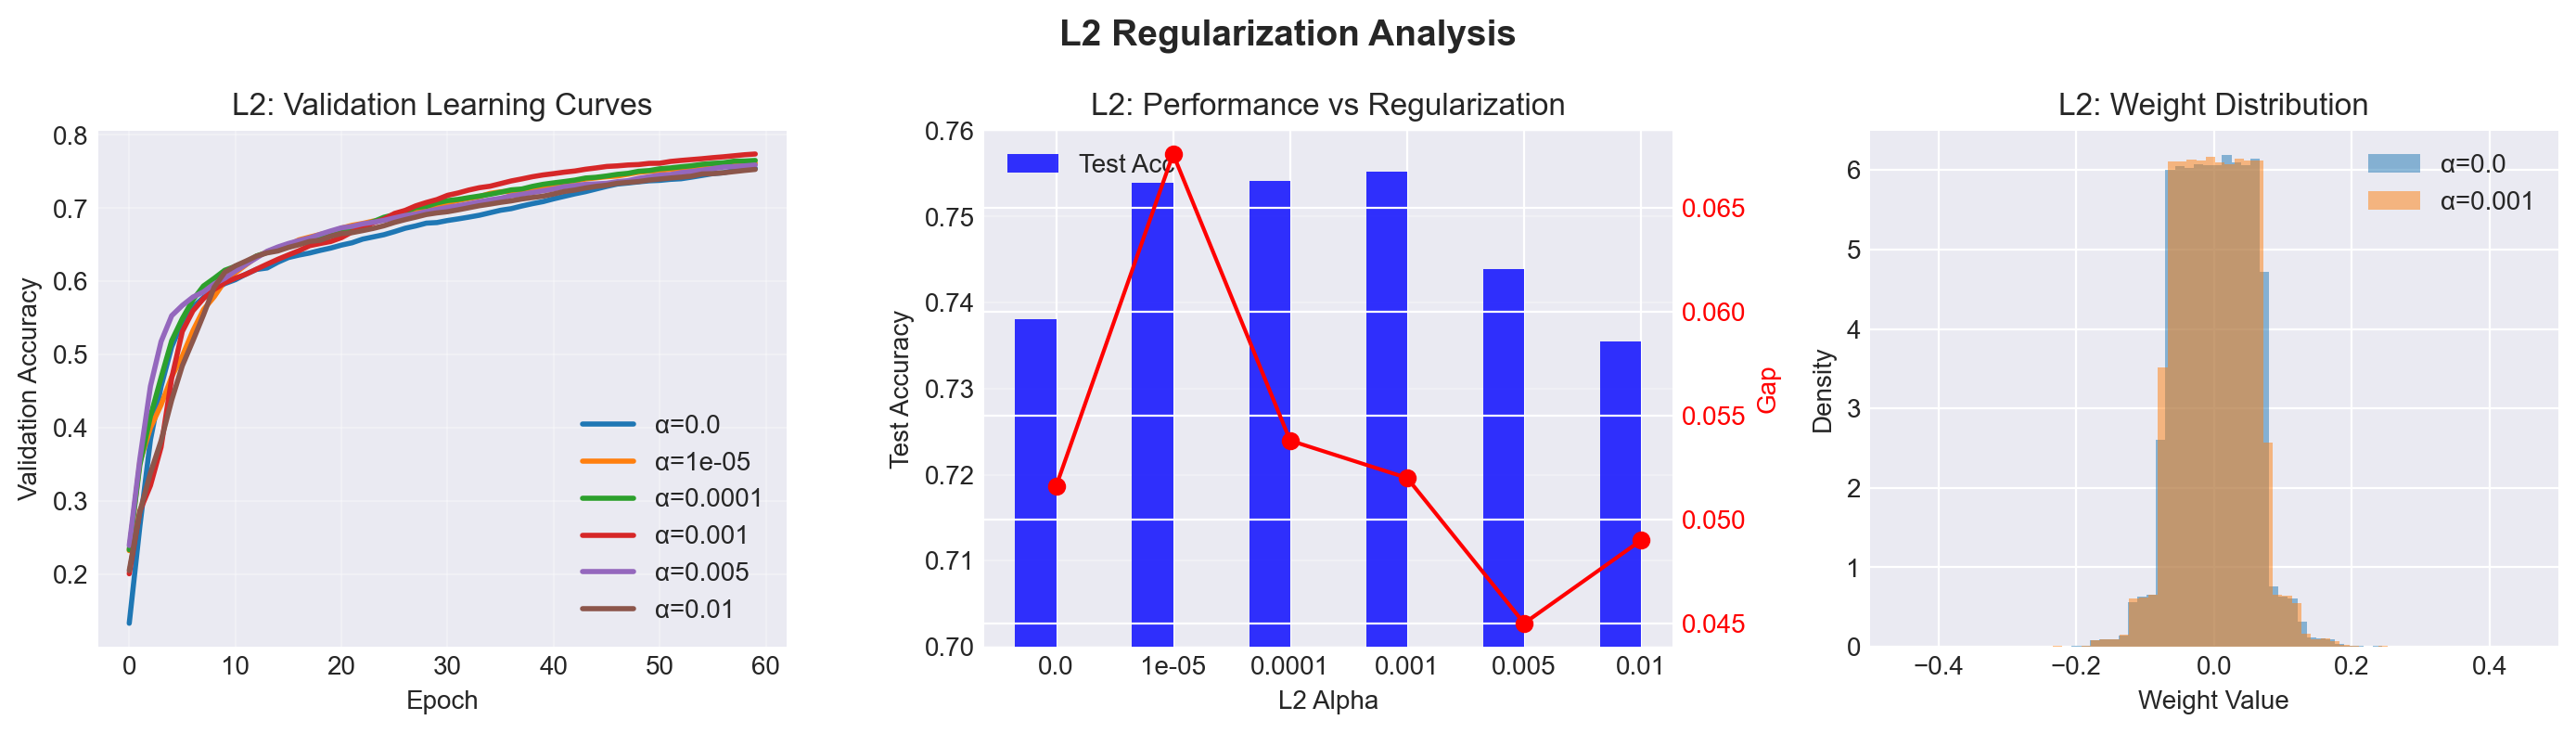

In [69]:
import matplotlib.pyplot as plt

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Panel 1: Learning curves
ax = axes[0]
for alpha in l2_alphas:
    ax.plot(sgd_mb_results[alpha]['history']['val_accuracy'], 
            label=f'α={alpha}', linewidth=2)
ax.set_xlabel('Epoch')
ax.set_ylabel('Validation Accuracy')
ax.set_title('L2: Validation Learning Curves')
ax.legend()
ax.grid(True, alpha=0.3)

# Panel 2: Test accuracy and gap
ax = axes[1]
x = np.arange(len(l2_alphas))
test_accs = [sgd_mb_results[a]['test_acc'] for a in l2_alphas]
gaps = [sgd_mb_results[a]['gap'] for a in l2_alphas]

width = 0.35
ax.bar(x - width/2, test_accs, width, label='Test Acc', alpha=0.8, color='blue')
# If you want to overlay the gap as a line:
ax2 = ax.twinx()
ax2.plot(x, gaps, color='red', marker='o', label='Train–Val Gap')
ax2.set_ylabel('Gap', color='red')
ax2.tick_params(axis='y', labelcolor='red')

ax.set_xlabel('L2 Alpha')
ax.set_ylabel('Test Accuracy')
ax.set_title('L2: Performance vs Regularization')
ax.set_xticks(x)
ax.set_xticklabels([str(a) for a in l2_alphas], rotation=0)
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0.7, 0.76])

# Panel 3: Weight distribution
ax = axes[2]
# Compare baseline vs best alpha found by validation accuracy
best_alpha = max(l2_alphas, key=lambda a: sgd_mb_results[a]['val_acc'])
compare_alphas = [0.0] if best_alpha == 0.0 else [0.0, best_alpha]
compare_alphas = [0.0,1e-3]

for alpha in compare_alphas:
    # Quick train a small model to visualize weight distribution (as in your approach)
    model_tmp = create_model_with_l2(alpha)
    model_tmp.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    model_tmp.fit(X_train[:500], y_train[:500], epochs=20, verbose=0)
    weights = []
    for layer in model_tmp.layers:
        if hasattr(layer, 'kernel') and layer.kernel is not None:
            weights.extend(layer.kernel.numpy().ravel())
    ax.hist(weights, bins=50, alpha=0.5, label=f'α={alpha}', density=True)

ax.set_xlabel('Weight Value')
ax.set_ylabel('Density')
ax.set_title('L2: Weight Distribution')
ax.legend()
ax.set_xlim([-0.5, 0.5])

plt.suptitle('L2 Regularization Analysis', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


**L2 Regularization Insights:**
- Forces weights toward zero but rarely exactly zero
- Creates smoother decision boundaries
- Equivalent to assuming Gaussian prior on weights
- Reduces model's sensitivity to individual features



### L1 Regularization - Feature Selection


L1 adds a penalty proportional to the absolute values of the weights, encouraging **sparsity** (many exact zeros) and implicit feature selection.

Objective:
$$
\min_{\theta}\;
\frac{1}{n}\sum_{i=1}^{n}\mathcal{L}\!\left(f(x_i;\theta),\,y_i\right)
\;+\;
\alpha \sum_{\ell}\|W_\ell\|_{1}.
$$

Subgradient and SGD-style update:
$$
\partial_{W_\ell}\!\left(\alpha \|W_\ell\|_{1}\right)=\alpha\,\mathrm{sign}(W_\ell)
\quad(\text{with subgradient in }[-\alpha,\alpha]\text{ at }0),
$$
$$
W_\ell \leftarrow W_\ell - \eta\Big(\nabla_{W_\ell}\mathcal{L} + \alpha\,\mathrm{sign}(W_\ell)\Big).
$$

Proximal view (soft-thresholding effect):
$$
\operatorname{soft}(w;\,\eta\alpha)=\mathrm{sign}(w)\,\max\!\big(|w|-\eta\alpha,\,0\big),
$$
which pulls small weights exactly to zero.

Key points:
- Produces sparse weights → simpler models, feature selection.
- Typically reduces the train–validation gap; too-large $\alpha$ can underfit.
- Common practice: apply the penalty to kernels (not biases) and tune $\alpha$ on a log scale.

In [61]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
# ================================
# L1: Same model + training config
# ================================
def create_model_with_l1(l1_alpha=0.0):
    """Simple MLP for 28x28 inputs; only L1 on kernels (no other regularization)."""
    reg = tf.keras.regularizers.l1(l1_alpha) if l1_alpha and l1_alpha > 0 else None
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=reg),
        tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=reg),
        tf.keras.layers.Dense(64,  activation='relu', kernel_regularizer=reg),
        tf.keras.layers.Dense(10,  activation='softmax')
    ])
    return model

def train_minibatch_sgd_l1(
    l1_alpha,
    X_train, y_train, X_val, y_val, X_test, y_test,
    lr=0.01, batch_size=128, epochs=60, seed=1337
):
    """
    Train with minibatch SGD (no momentum), only L1 on kernels.
    No early stopping to isolate L1’s effect.
    """
    tf.keras.backend.clear_session()
    tf.random.set_seed(seed)
    np.random.seed(seed)

    model = create_model_with_l1(l1_alpha)
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr)  # vanilla SGD

    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        shuffle=True,
        verbose=0
    )

    # Evaluate
    train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
    val_loss,   val_acc   = model.evaluate(X_val,   y_val,   verbose=0)
    test_loss,  test_acc  = model.evaluate(X_test,  y_test,  verbose=0)

    # Weights + stats for sparsity analysis
    weights = []
    for layer in model.layers:
        if hasattr(layer, 'kernel') and layer.kernel is not None:
            weights.extend(layer.kernel.numpy().ravel())
    weights = np.array(weights) if len(weights) else np.array([0.0])

    results = {
        'train_acc': float(train_acc),
        'val_acc':   float(val_acc),
        'test_acc':  float(test_acc),
        'gap':       float(train_acc - val_acc),
        'weights':     weights,
        'weight_mean': float(np.mean(np.abs(weights))),
        'weight_std':  float(np.std(weights)),
        'sparsity':    float(np.mean(np.abs(weights) < 1e-4)),  # ~exact zeros
        'num_zeros':   int(np.sum(np.abs(weights) < 1e-4)),
        'history':     history.history
    }
    return model, results

# ===========================================
# Sweep L1 strengths with MINIBATCH SGD
# ===========================================
print("\nTraining with MINIBATCH SGD (vanilla) and L1 only...")
print("-" * 60)

l1_alphas = [0.0, 1e-4, 5e-4, 1e-3, 5e-3]  # your original values; adjust if needed
sgd_mb_l1_results = {}

for alpha in l1_alphas:
    print(f"L1 α={alpha:g} (batch_size=128, lr=0.01, epochs=60)")
    model, res = train_minibatch_sgd_l1(
        l1_alpha=alpha,
        X_train=X_train, y_train=y_train,
        X_val=X_val, y_val=y_val,
        X_test=X_test, y_test=y_test,
        lr=0.01, batch_size=128, epochs=60, seed=1337
    )
    sgd_mb_l1_results[alpha] = res
    print(f"  Val: {res['val_acc']:.3f} | Test: {res['test_acc']:.3f} | "
          f"Gap: {res['gap']:.3f} | Sparsity: {res['sparsity']:.1%} | "
          f"Zeros: {res['num_zeros']}")




Training with MINIBATCH SGD (vanilla) and L1 only...
------------------------------------------------------------
L1 α=0 (batch_size=128, lr=0.01, epochs=60)
  Val: 0.757 | Test: 0.739 | Gap: 0.048 | Sparsity: 0.1% | Zeros: 295
L1 α=0.0001 (batch_size=128, lr=0.01, epochs=60)
  Val: 0.770 | Test: 0.757 | Gap: 0.058 | Sparsity: 0.4% | Zeros: 884
L1 α=0.0005 (batch_size=128, lr=0.01, epochs=60)
  Val: 0.755 | Test: 0.740 | Gap: 0.039 | Sparsity: 2.3% | Zeros: 5671
L1 α=0.001 (batch_size=128, lr=0.01, epochs=60)
  Val: 0.760 | Test: 0.744 | Gap: 0.051 | Sparsity: 5.5% | Zeros: 13240
L1 α=0.005 (batch_size=128, lr=0.01, epochs=60)
  Val: 0.716 | Test: 0.707 | Gap: 0.036 | Sparsity: 28.9% | Zeros: 69923


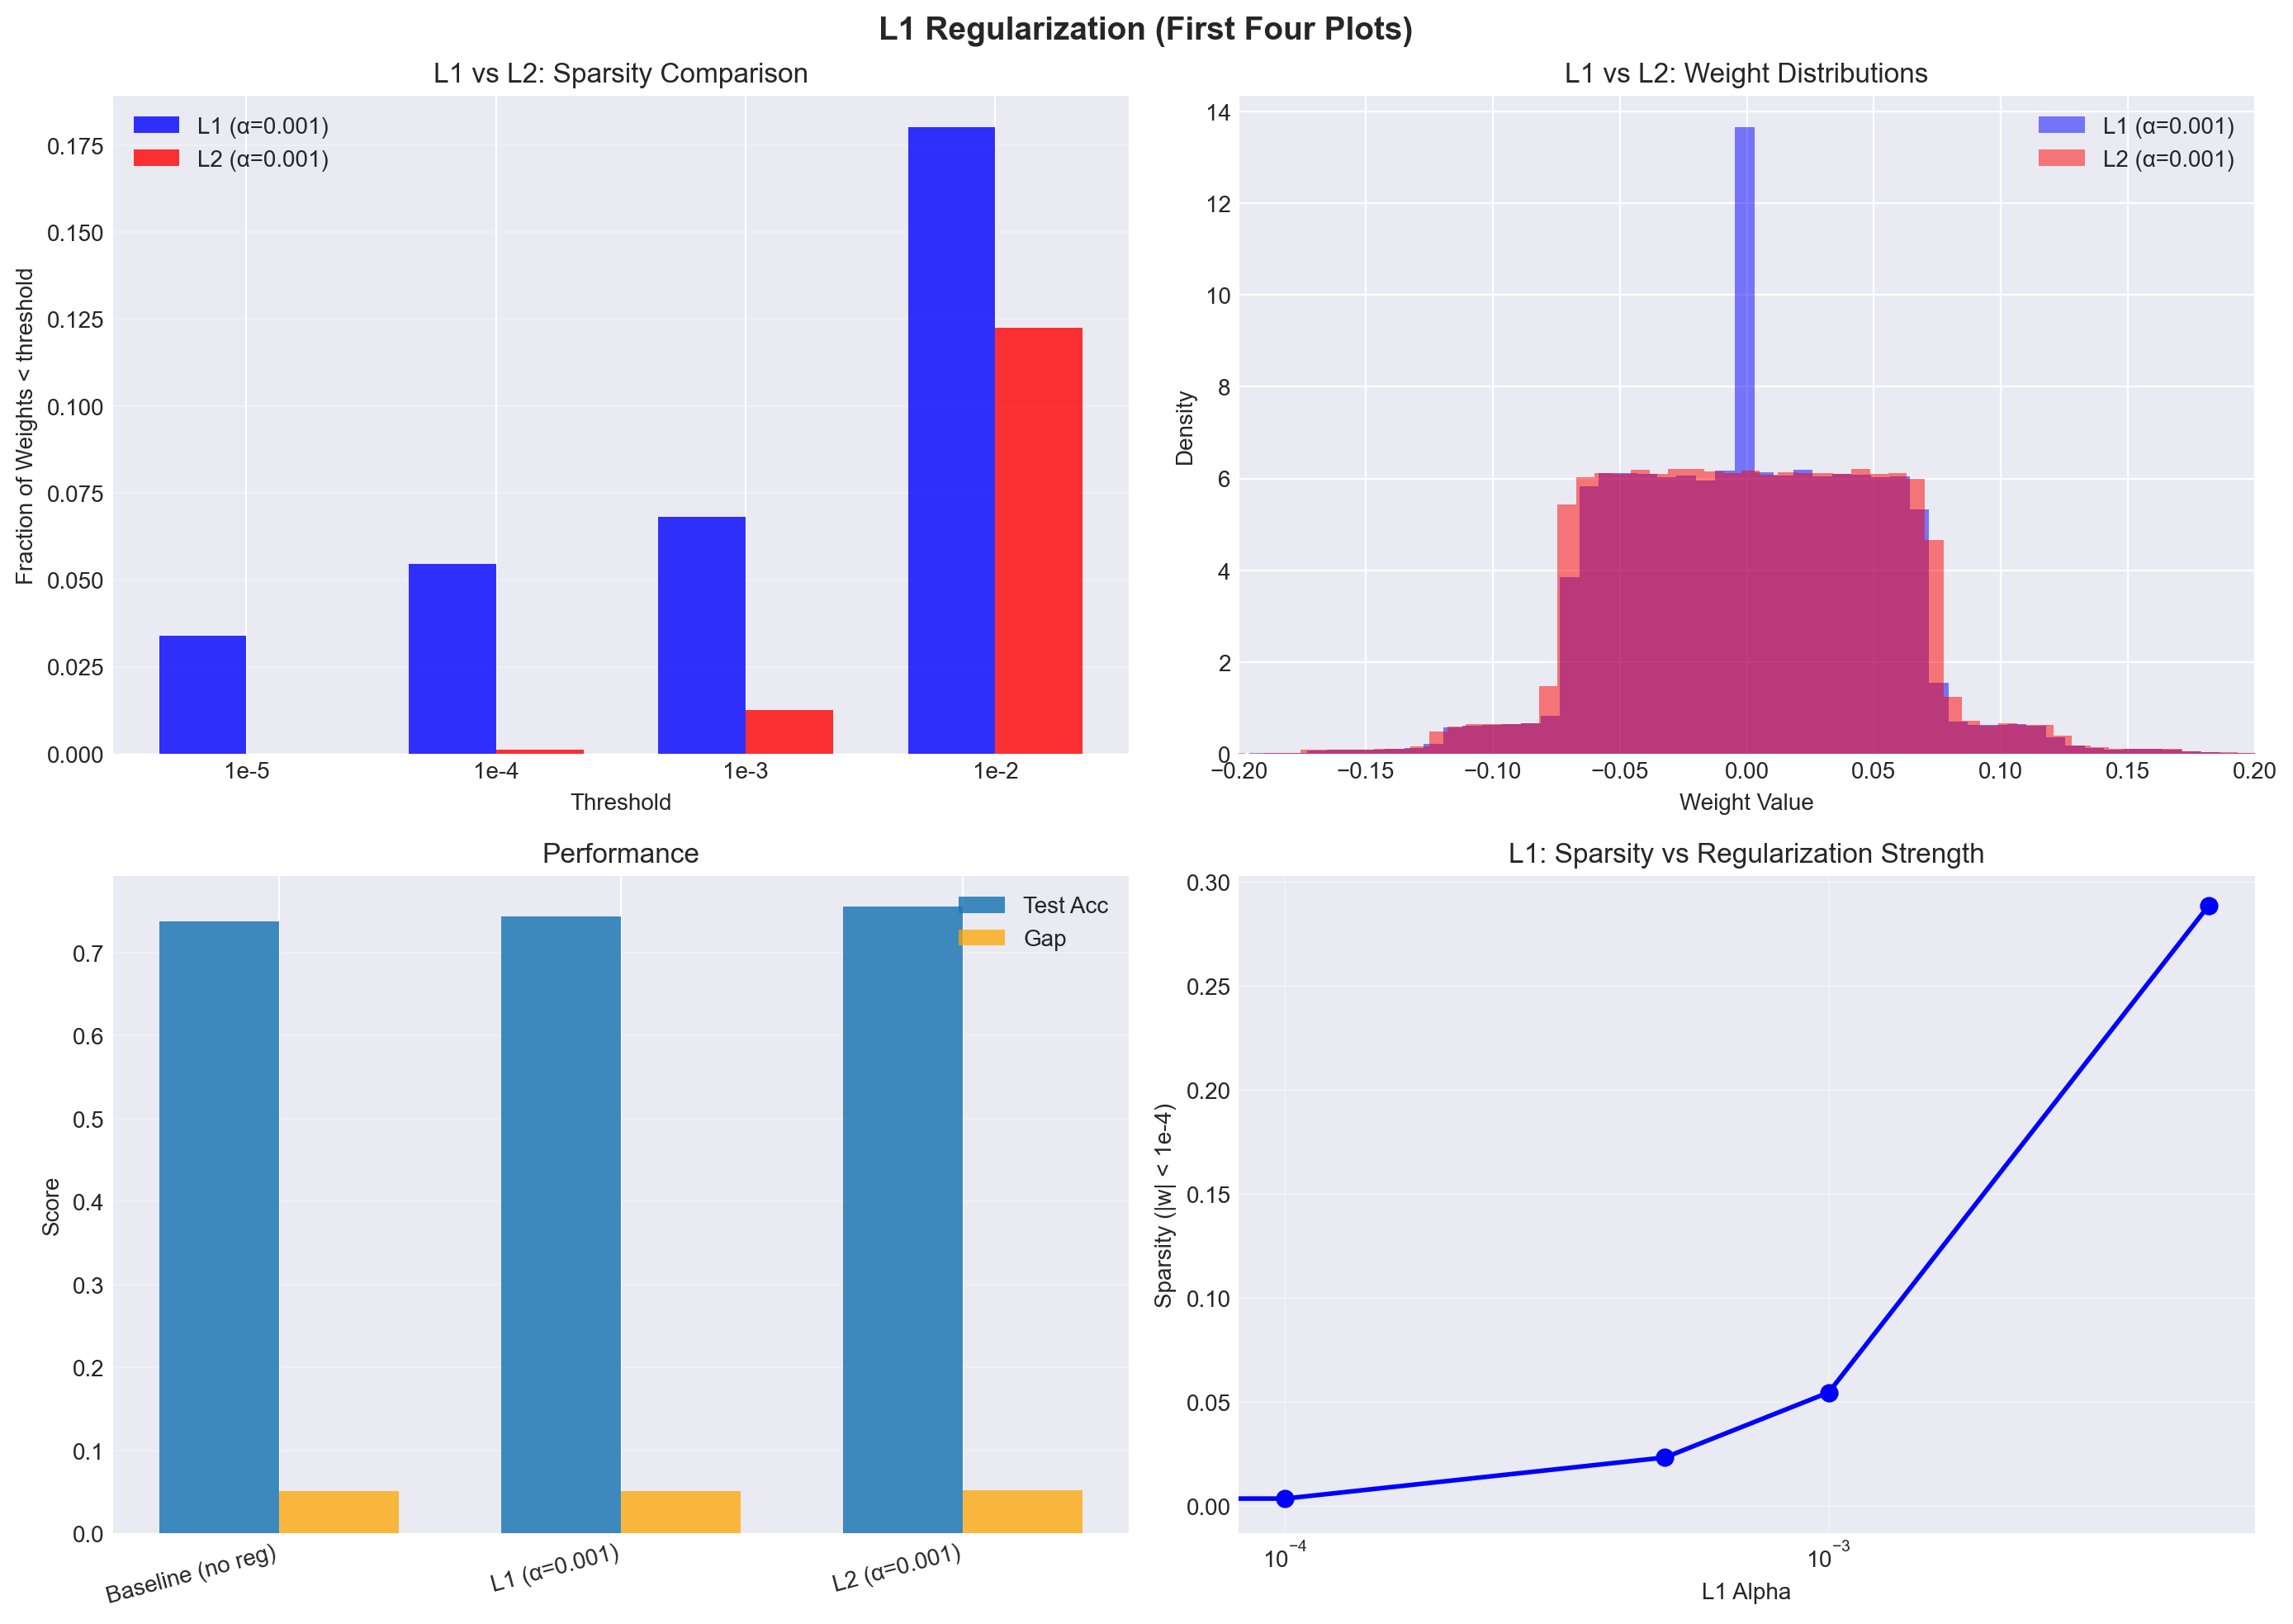

In [73]:
# Choose best alphas by validation accuracy
# best_l1_alpha = max(sgd_mb_l1_results.keys(), key=lambda a: sgd_mb_l1_results[a]['val_acc'])
best_l1_alpha = 1e-3
l1_w_best = sgd_mb_l1_results[best_l1_alpha]['weights']

best_l2_alpha = None
l2_w_best = None
if 'sgd_mb_results' in globals() and len(sgd_mb_results) > 0:
    best_l2_alpha = max(sgd_mb_results.keys(), key=lambda a: sgd_mb_results[a]['val_acc'])
    l2_w_best = sgd_mb_results[best_l2_alpha].get('weights', None)  # no auto-retrain

# 2×2 figure
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# (1) L1 vs L2: Sparsity comparison (multiple thresholds)
ax = axes[0, 0]
thresholds = [1e-5, 1e-4, 1e-3, 1e-2]
l1_sparsity_levels = [np.mean(np.abs(l1_w_best) < t) for t in thresholds]
x = np.arange(len(thresholds)); width = 0.35
ax.bar(x - width/2, l1_sparsity_levels, width, label=f'L1 (α={best_l1_alpha})', alpha=0.8, color='blue')
if l2_w_best is not None:
    l2_sparsity_levels = [np.mean(np.abs(l2_w_best) < t) for t in thresholds]
    ax.bar(x + width/2, l2_sparsity_levels, width, label=f'L2 (α={best_l2_alpha})', alpha=0.8, color='red')
ax.set_xlabel('Threshold')
ax.set_ylabel('Fraction of Weights < threshold')
ax.set_title('L1 vs L2: Sparsity Comparison')
ax.set_xticks(x); ax.set_xticklabels(['1e-5','1e-4','1e-3','1e-2'])
ax.legend(); ax.grid(True, alpha=0.3, axis='y')

# (2) Weight distributions (overlay if L2 weights available)
ax = axes[0, 1]
ax.hist(l1_w_best, bins=100, alpha=0.5, label=f'L1 (α={best_l1_alpha})', density=True, color='blue')
if l2_w_best is not None:
    ax.hist(l2_w_best, bins=100, alpha=0.5, label=f'L2 (α={best_l2_alpha})', density=True, color='red')
ax.set_xlabel('Weight Value'); ax.set_ylabel('Density')
ax.set_title('L1 vs L2: Weight Distributions')
ax.set_xlim([-0.2, 0.2]); ax.legend()

# (3) Performance comparison bars (Baseline vs Best L1 vs Best L2)
ax = axes[1, 0]
methods, test_accs, gaps = [], [], []

# Baseline from L2 sweep if present
if 'sgd_mb_results' in globals() and 0.0 in sgd_mb_results:
    methods.append('Baseline (no reg)')
    test_accs.append(sgd_mb_results[0.0]['test_acc'])
    gaps.append(sgd_mb_results[0.0]['gap'])

# Best L1
methods.append(f'L1 (α={best_l1_alpha})')
test_accs.append(sgd_mb_l1_results[best_l1_alpha]['test_acc'])
gaps.append(sgd_mb_l1_results[best_l1_alpha]['gap'])

# Best L2 (if available)
if 'sgd_mb_results' in globals() and best_l2_alpha is not None:
    methods.append(f'L2 (α={best_l2_alpha})')
    test_accs.append(sgd_mb_results[best_l2_alpha]['test_acc'])
    gaps.append(sgd_mb_results[best_l2_alpha]['gap'])

x = np.arange(len(methods)); width = 0.35
ax.bar(x - width/2, test_accs, width, label='Test Acc', alpha=0.85)
ax.bar(x + width/2, gaps, width, label='Gap', alpha=0.75, color='orange')
ax.set_ylabel('Score'); ax.set_title('Performance')
ax.set_xticks(x); ax.set_xticklabels(methods, rotation=15, ha='right')
ax.legend(); ax.grid(True, alpha=0.3, axis='y')

# (4) L1: sparsity vs alpha
ax = axes[1, 1]
l1_alphas_sorted = sorted(sgd_mb_l1_results.keys())
sparsity_by_alpha = [sgd_mb_l1_results[a]['sparsity'] for a in l1_alphas_sorted]
ax.plot(l1_alphas_sorted, sparsity_by_alpha, 'o-', linewidth=2, markersize=7, color='blue')
ax.set_xscale('log' if any(a > 0 for a in l1_alphas_sorted) else 'linear')
ax.set_xlabel('L1 Alpha'); ax.set_ylabel('Sparsity (|w| < 1e-4)')
ax.set_title('L1: Sparsity vs Regularization Strength')
ax.grid(True, alpha=0.3)

plt.suptitle('L1 Regularization (First Four Plots)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

**L1 vs L2 Key Differences:**
- L1 creates sparse solutions (many exact zeros)
- L2 creates dense but small weights
- L1 is better for feature selection
- L2 is better for general regularization

### Early Stopping - Know When to Quit

Early stopping monitors validation performance and stops training when it stops improving, using validation data as a guide.

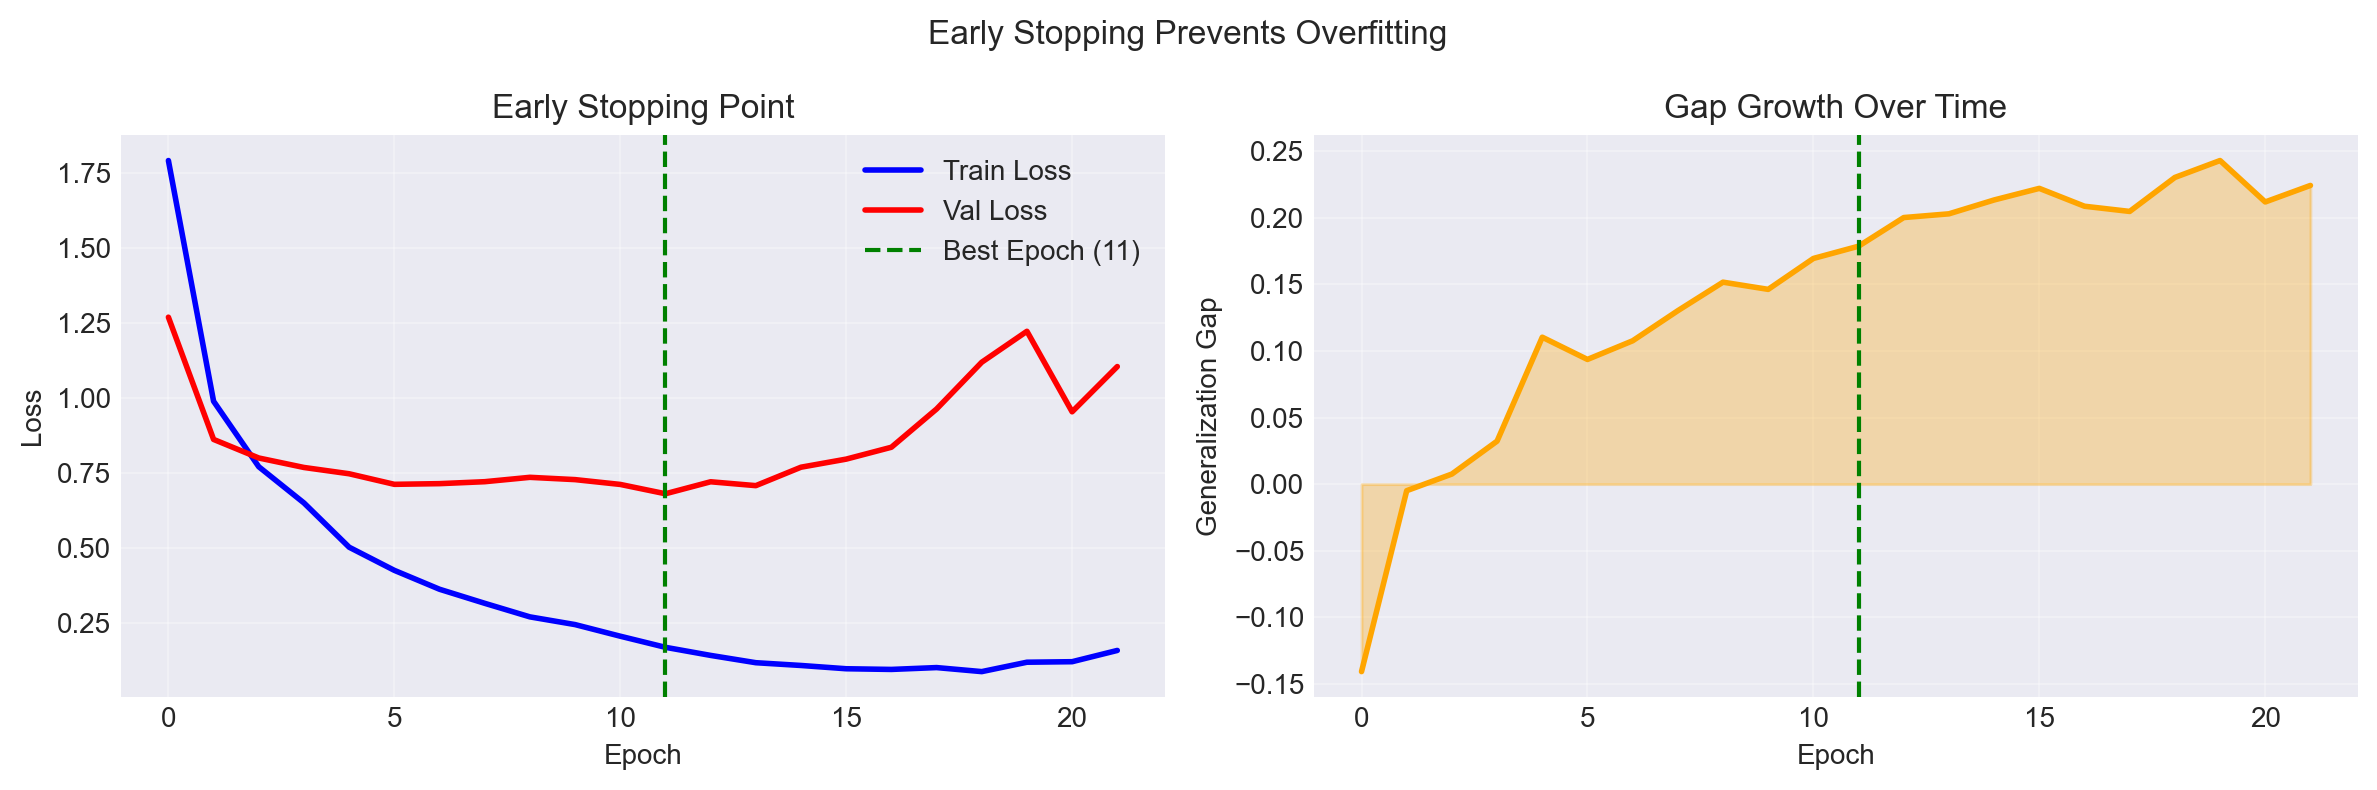

In [78]:
class EarlyStoppingVisualizer(tf.keras.callbacks.Callback):
    """Custom callback to visualize early stopping behavior"""
    def __init__(self, patience=10):
        super().__init__()
        self.patience = patience
        self.wait = 0
        self.best_val_loss = np.inf
        self.best_epoch = 0
        
    def on_epoch_end(self, epoch, logs=None):
        current_val_loss = logs.get('val_loss')
        
        if current_val_loss < self.best_val_loss:
            self.best_val_loss = current_val_loss
            self.best_epoch = epoch
            self.wait = 0
        else:
            self.wait += 1
            
        if self.wait >= self.patience:
            self.model.stop_training = True

# Train with early stopping
model_es = create_model()
early_stop = EarlyStoppingVisualizer(patience=10)

history_es = model_es.fit(X_train_proper, y_train_proper,
                         validation_data=(X_val, y_val),
                         epochs=100,
                         callbacks=[early_stop],
                         verbose=0)

# Visualize early stopping effect
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Loss curves
ax = axes[0]
epochs = range(len(history_es.history['loss']))
ax.plot(epochs, history_es.history['loss'], 'b-', label='Train Loss', linewidth=2)
ax.plot(epochs, history_es.history['val_loss'], 'r-', label='Val Loss', linewidth=2)
ax.axvline(x=early_stop.best_epoch, color='green', linestyle='--', 
          label=f'Best Epoch ({early_stop.best_epoch})')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Early Stopping Point')
ax.legend()
ax.grid(True, alpha=0.3)

# Gap evolution
ax = axes[1]
gap = np.array(history_es.history['accuracy']) - np.array(history_es.history['val_accuracy'])
ax.plot(epochs, gap, linewidth=2, color='orange')
ax.fill_between(epochs, 0, gap, alpha=0.3, color='orange')
ax.axvline(x=early_stop.best_epoch, color='green', linestyle='--')
ax.set_xlabel('Epoch')
ax.set_ylabel('Generalization Gap')
ax.set_title('Gap Growth Over Time')
ax.grid(True, alpha=0.3)

plt.suptitle('Early Stopping Prevents Overfitting')
plt.tight_layout()
plt.show()

**Early Stopping Strategy:**
- Monitor validation loss, not training loss
- Use patience parameter to avoid stopping on noise
- Save best weights and restore them at the end
- Free regularization that requires no model changes

## Part 4: Modern Regularization Techniques

### Label Smoothing - Preventing Overconfidence

Label smoothing replaces hard labels (0 or 1) with soft labels, preventing the model from becoming overconfident.

In K-class classification we usually train with one‑hot targets and minimize cross‑entropy against the model’s predicted probabilities q. Hard labels drive the model to push the correct class probability toward 1, which often produces overconfident and poorly calibrated predictions.

Label smoothing replaces the hard target with a softened distribution controlled by α ∈ [0, 1):

- For class k ∈ {1,…,K} and true label y:
  $$
  \tilde{y}_k \;=\; (1-\alpha)\,\mathbf{1}\{k=y\} \;+\; \frac{\alpha}{K}.
  $$
- Vector form with one‑hot y and the uniform distribution u over K classes:
  $$
  \tilde{\mathbf{y}} \;=\; (1-\alpha)\,\mathrm{one\_hot}(y) \;+\; \alpha\,\mathbf{u}.
  $$

The training loss becomes cross‑entropy with the smoothed target:
$$
\mathcal{L} \;=\; -\sum_{k=1}^{K} \tilde{y}_k \log q_k
\;=\; (1-\alpha)\,\mathrm{CE}(\mathrm{one\_hot}(y), q)\;+\;\alpha\,\mathrm{CE}(\mathbf{u}, q).
$$


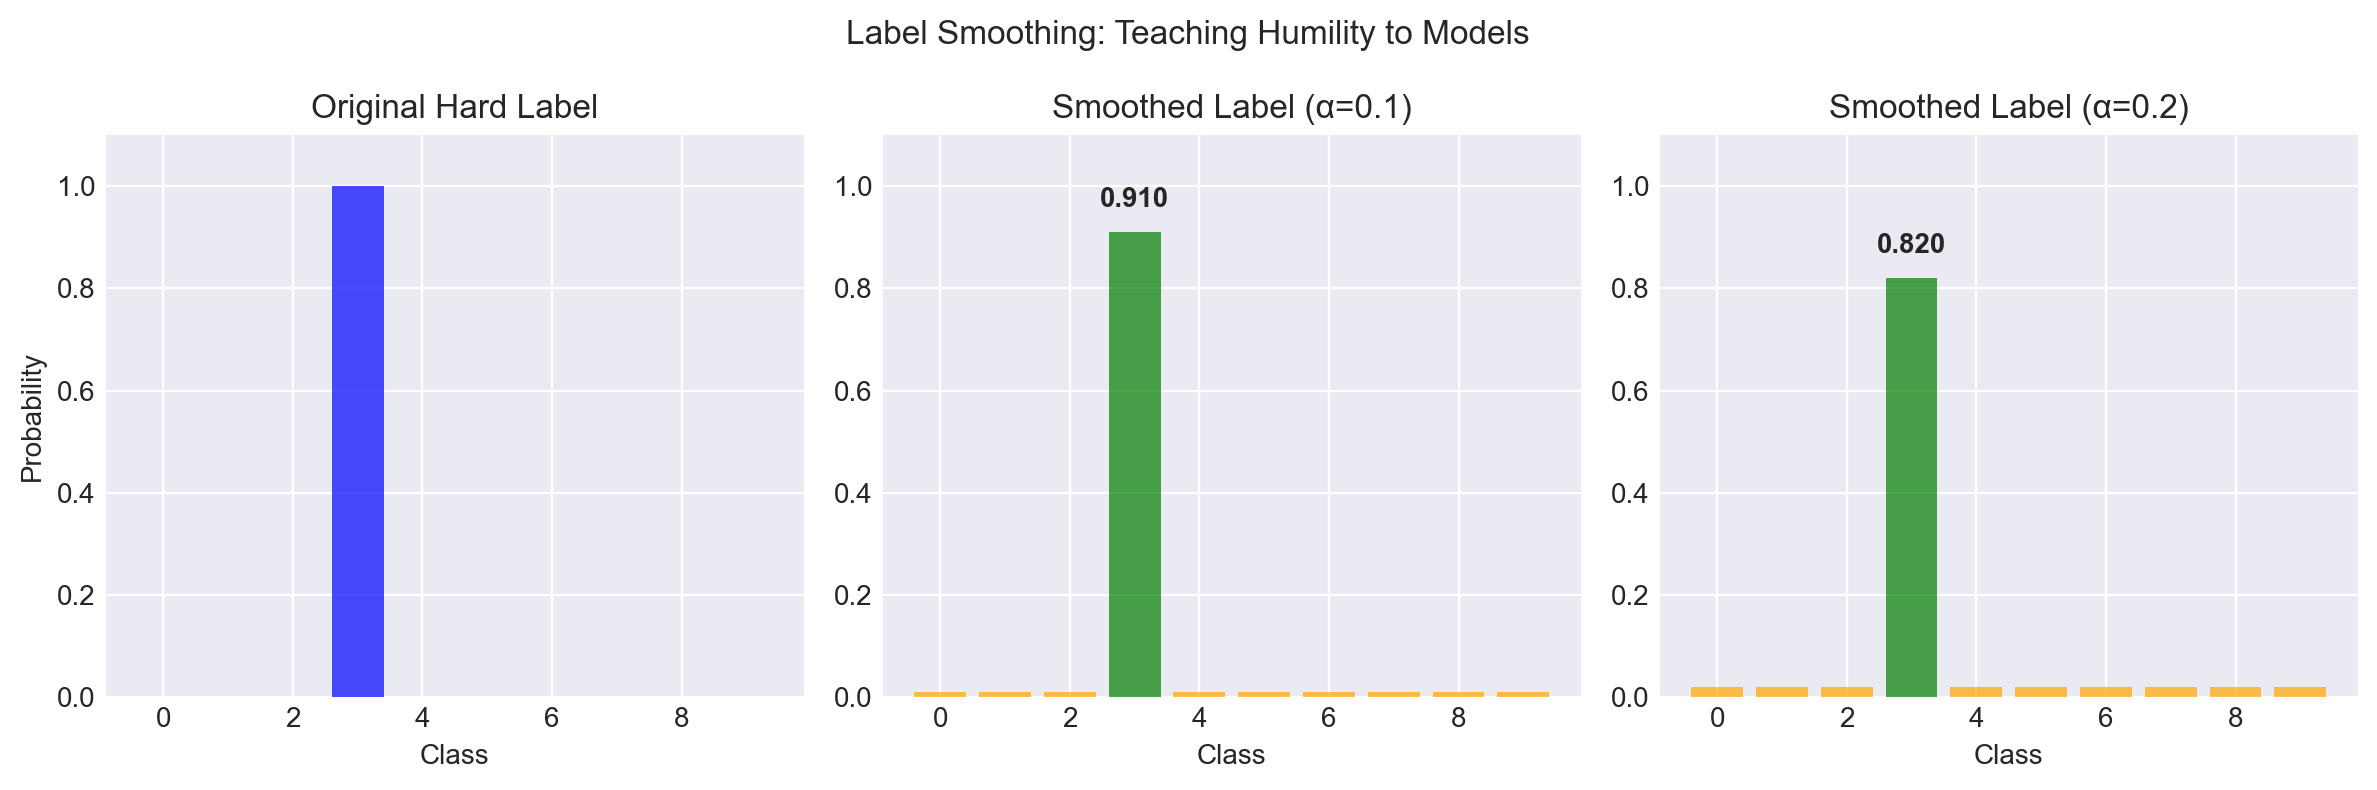

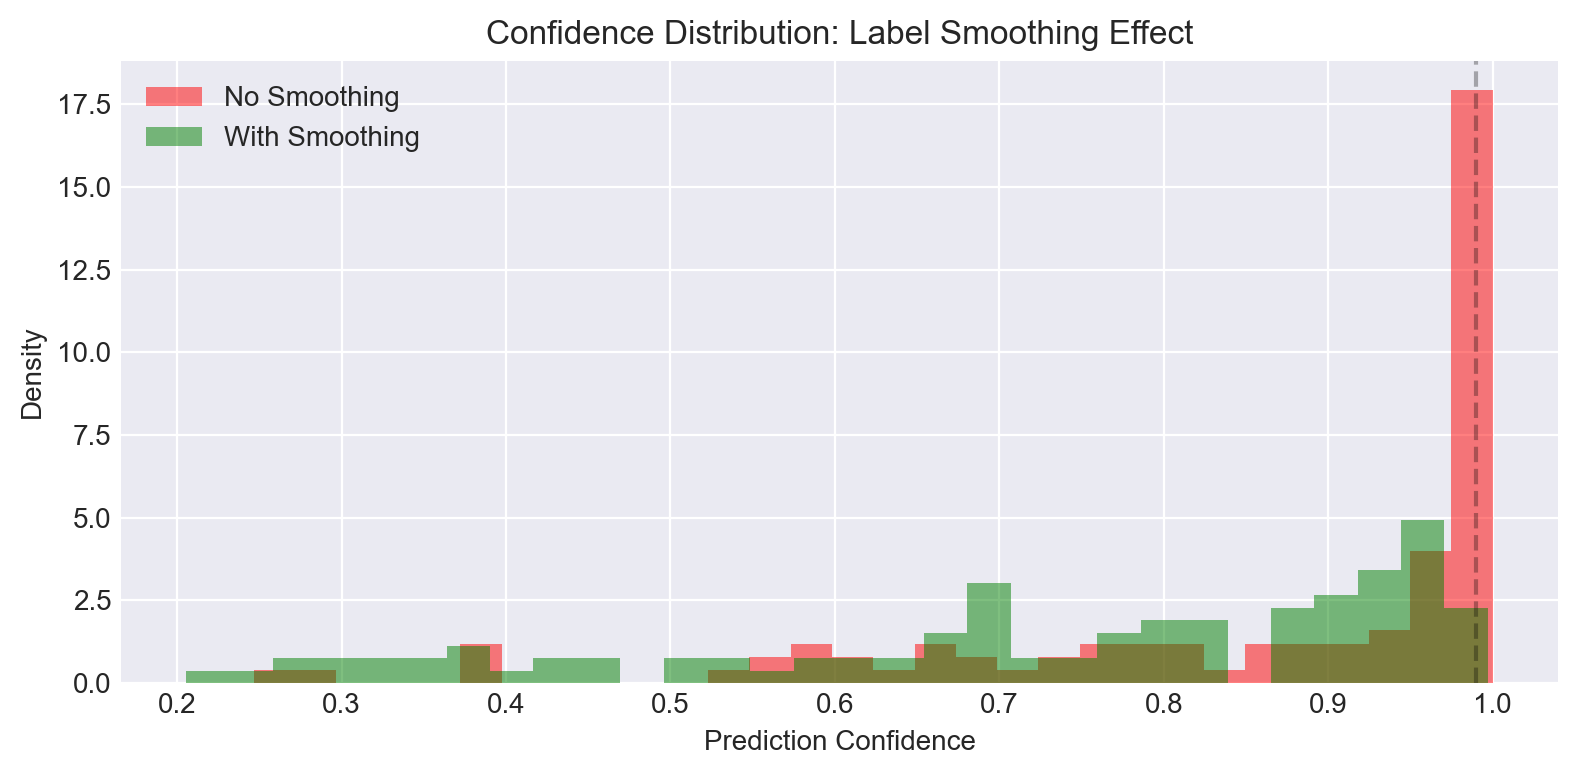

In [79]:
def visualize_label_smoothing(num_classes=10, positive_class=3, alphas=(0.1, 0.2)):
    """Visualize the effect of label smoothing on target distributions."""
    fig, axes = plt.subplots(1, 1 + len(alphas), figsize=(12, 4))

    # Original hard label (one-hot on positive_class)
    original = np.zeros(num_classes, dtype=np.float32)
    original[positive_class] = 1.0

    ax = axes[0]
    ax.bar(range(num_classes), original, color='blue', alpha=0.7)
    ax.set_title('Original Hard Label')
    ax.set_ylabel('Probability')
    ax.set_ylim([0, 1.1])
    ax.set_xlabel('Class')

    # Smoothed labels
    for i, alpha in enumerate(alphas):
        ax = axes[i + 1]
        smoothed = original * (1 - alpha) + alpha / float(num_classes)
        colors = ['green' if j == positive_class else 'orange' for j in range(num_classes)]
        ax.bar(range(num_classes), smoothed, color=colors, alpha=0.7)
        ax.set_title(f'Smoothed Label (α={alpha})')
        ax.set_ylim([0, 1.1])
        ax.set_xlabel('Class')
        ax.text(positive_class, smoothed[positive_class] + 0.05, f'{smoothed[positive_class]:.3f}',
                ha='center', fontweight='bold')

    plt.suptitle('Label Smoothing: Teaching Humility to Models')
    plt.tight_layout()
    plt.show()

visualize_label_smoothing()

# --- Label smoothing for sparse integer labels (version-safe) ---
def make_sparse_cce_with_label_smoothing(alpha=0.1, num_classes=10):
    """
    Returns a loss that:
    - takes sparse integer y_true
    - converts to one-hot
    - applies label smoothing manually
    - computes categorical cross-entropy
    Works on TF versions where SparseCategoricalCrossentropy(label_smoothing=...) is unavailable.
    """
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
    alpha = float(alpha)
    num_classes = int(num_classes)

    def loss(y_true, y_pred):
        # y_true could be shape (batch,) or (batch, 1). Flatten to (batch,)
        y_true_flat = tf.cast(tf.reshape(y_true, (-1,)), tf.int32)
        y_true_oh = tf.one_hot(y_true_flat, depth=num_classes, dtype=tf.float32)
        y_true_smooth = y_true_oh * (1.0 - alpha) + alpha / float(num_classes)
        return cce(y_true_smooth, y_pred)

    return loss

def create_model_with_label_smoothing(alpha=0.1, num_classes=10):
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss=make_sparse_cce_with_label_smoothing(alpha=alpha, num_classes=num_classes),
        metrics=['accuracy']  # keeps sparse accuracy with int y_true
    )
    return model

# If create_model() isn't defined earlier in your notebook, uncomment this fallback:
# def create_model(num_classes=10):
#     model = tf.keras.Sequential([
#         tf.keras.layers.Flatten(input_shape=(28, 28)),
#         tf.keras.layers.Dense(256, activation='relu'),
#         tf.keras.layers.Dense(128, activation='relu'),
#         tf.keras.layers.Dense(64, activation='relu'),
#         tf.keras.layers.Dense(num_classes, activation='softmax')
#     ])
#     model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#     return model

# --- Train and compare confidence distributions ---
model_hard = create_model()
model_smooth = create_model_with_label_smoothing(alpha=0.1, num_classes=10)

model_hard.fit(X_train_proper, y_train_proper, epochs=20, verbose=0)
model_smooth.fit(X_train_proper, y_train_proper, epochs=20, verbose=0)

# Get predictions
pred_hard = model_hard.predict(X_val[:100], verbose=0)
pred_smooth = model_smooth.predict(X_val[:100], verbose=0)

# Visualize confidence distributions
fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(np.max(pred_hard, axis=1), bins=30, alpha=0.5,
        label='No Smoothing', color='red', density=True)
ax.hist(np.max(pred_smooth, axis=1), bins=30, alpha=0.5,
        label='With Smoothing', color='green', density=True)
ax.set_xlabel('Prediction Confidence')
ax.set_ylabel('Density')
ax.set_title('Confidence Distribution: Label Smoothing Effect')
ax.legend()
ax.axvline(x=0.99, color='black', linestyle='--', alpha=0.3,
           label='Overconfident Threshold')
plt.tight_layout()
plt.show()

Effects and benefits:

- Encourages higher‑entropy (less peaky) predictions and smaller logits.
- Reduces overfitting and improves probability calibration.
- Provides robustness to label noise. Typical choices: $\alpha \in [0.05,\,0.2]$.

Practical notes:

- Use softmax outputs and match the loss to your outputs:
  - probabilities: `from_logits=False`
  - logits: `from_logits=True`
- With sparse integer labels, either rely on a TF version that supports `label_smoothing` in `SparseCategoricalCrossentropy`, or convert to one‑hot inside a custom loss (as done in the code below).

### Mixup - Data Augmentation Through Blending

### What is Mixup?

Mixup is a data‑augmentation strategy that creates new “virtual” training examples by linearly interpolating pairs of samples and their labels. Given two training examples (xi, yi) and (xj, yj) with one‑hot labels, we draw a mixing coefficient λ from a Beta distribution and form

$$
\tilde{\mathbf{x}}=\lambda\,\mathbf{x}_i+(1-\lambda)\,\mathbf{x}_j,\qquad
\tilde{\mathbf{y}}=\lambda\,\mathbf{y}_i+(1-\lambda)\,\mathbf{y}_j,
\quad \lambda \sim \mathrm{Beta}(\alpha,\alpha),\ \alpha>0.
$$

Intuitively, this is like overlaying image j on image i with “opacity” 1−λ, while the target becomes the same convex combination of their labels.

### How it works and why it helps

- It trains the model to behave linearly between classes, which regularizes decision boundaries and discourages memorization.
- It improves robustness to label noise and typically yields better calibration and generalization.
- The Beta parameter controls blend strength: small α produces λ near 0/1 (samples look original), larger α pushes λ toward 0.5 (visibly overlaid images).

When training with mixup, use a loss that accepts soft labels (e.g., CategoricalCrossentropy on one‑hot/probability targets).

**Optional Reading**: Application to cybersecurity domain [Zero-day Attack Detection in Digital Substations using In-Context Learning](https://ieeexplore.ieee.org/document/10738025/)

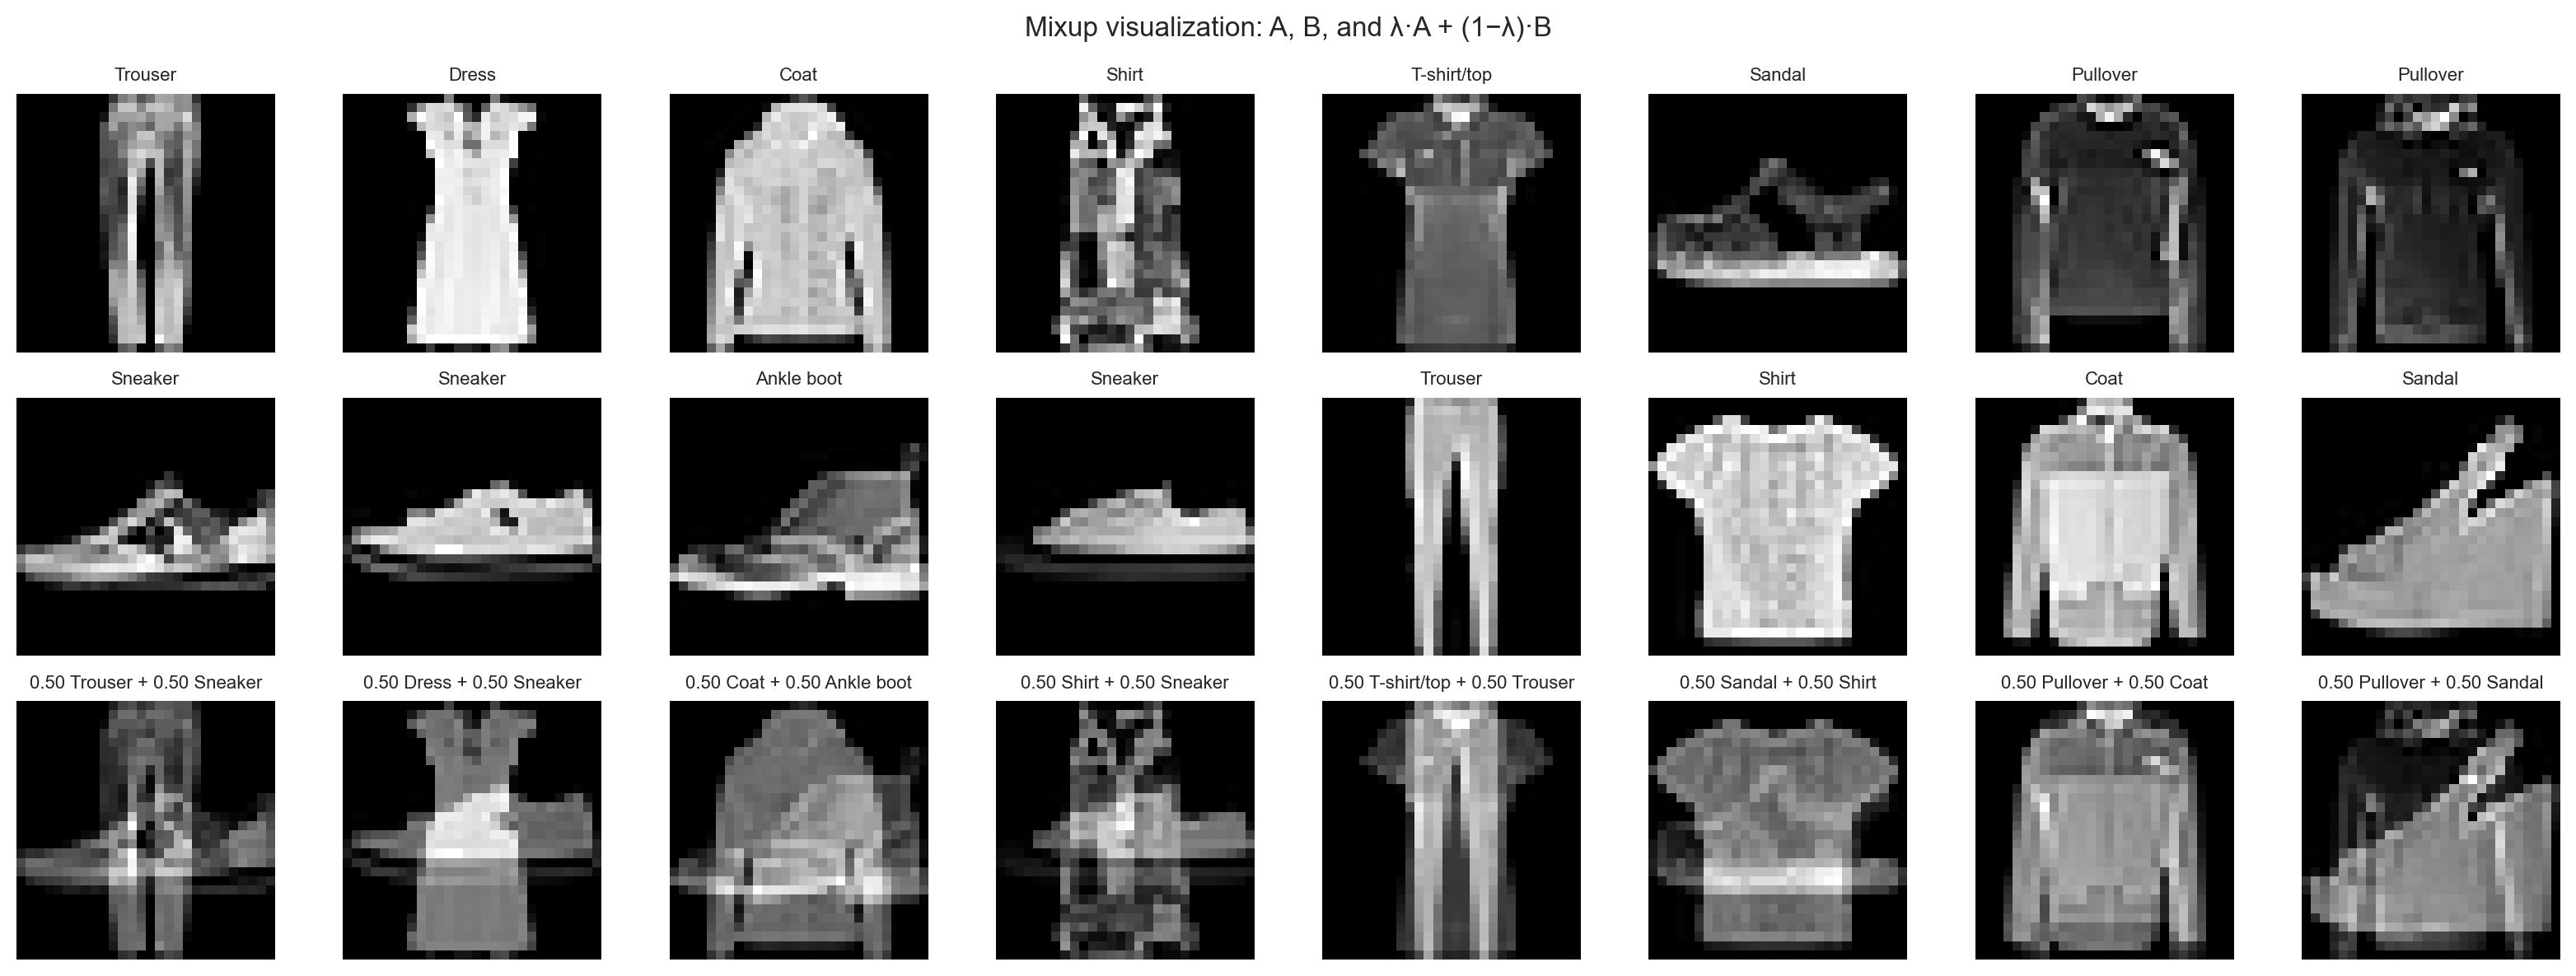

In [82]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

def mixup_batch(x, y, alpha=0.4, num_classes=10, per_sample=True):
    """Mixup with optional per-sample lambda."""
    x = x.astype('float32')
    bs = len(x)
    idx = np.random.permutation(bs)

    if per_sample:
        lam = np.random.beta(alpha, alpha, size=(bs,))
    else:
        lam = np.array([np.random.beta(alpha, alpha)] * bs)

    # reshape for broadcasting over H,W,(C)
    lam_img = lam.reshape((bs,) + (1,) * (x.ndim - 1))

    mixed_x = lam_img * x + (1.0 - lam_img) * x[idx]
    y_oh = tf.keras.utils.to_categorical(y, num_classes=num_classes)
    mixed_y = lam[:, None] * y_oh + (1.0 - lam)[:, None] * y_oh[idx]
    return mixed_x, mixed_y, lam, idx

# Clear, didactic viz: show source A, source B, and the mix
def show_mixup_triplets(x, y, class_names, k=6, lam_fixed=None, alpha=0.4):
    sel = np.random.permutation(len(x))[:k]
    # partner indices for the selected samples
    partners = np.random.permutation(len(x))[:k]

    if lam_fixed is None:
        lam = np.random.beta(alpha, alpha, size=(k,))
    else:
        lam = np.full((k,), lam_fixed, dtype='float32')

    lam_img = lam.reshape((k,) + (1,) * (x.ndim - 1))
    mixed = lam_img * x[sel] + (1.0 - lam_img) * x[partners]

    fig, axes = plt.subplots(3, k, figsize=(2*k, 6))
    for i in range(k):
        axes[0, i].imshow(x[sel[i]].squeeze(), cmap='gray')
        axes[0, i].set_title(class_names[y[sel[i]]], fontsize=8)
        axes[0, i].axis('off')

        axes[1, i].imshow(x[partners[i]].squeeze(), cmap='gray')
        axes[1, i].set_title(class_names[y[partners[i]]], fontsize=8)
        axes[1, i].axis('off')

        axes[2, i].imshow(mixed[i].squeeze(), cmap='gray')
        axes[2, i].set_title(f"{lam[i]:.2f} {class_names[y[sel[i]]]} + "
                             f"{1-lam[i]:.2f} {class_names[y[partners[i]]]}",
                             fontsize=8)
        axes[2, i].axis('off')

    axes[0, 0].set_ylabel('A', rotation=0, labelpad=20)
    axes[1, 0].set_ylabel('B', rotation=0, labelpad=20)
    axes[2, 0].set_ylabel('Mix', rotation=0, labelpad=20)
    plt.suptitle('Mixup visualization: A, B, and λ·A + (1−λ)·B')
    plt.tight_layout()
    plt.show()

# Usage (set lam_fixed=0.5 for a clearly "overlaid" look)
show_mixup_triplets(X_train_proper, y_train_proper, class_names, k=8, lam_fixed=0.5)
# Or sample per-sample lambdas:
# show_mixup_triplets(X_train_proper, y_train_proper, class_names, k=8, lam_fixed=None, alpha=0.8)

In [84]:
### Mixup - Interpolation-Based Augmentation

# Mixup creates virtual training examples by linearly interpolating pairs of examples
# x_mixed = λ*x_i + (1-λ)*x_j, y_mixed = λ*y_i + (1-λ)*y_j

def mixup_batch(x, y, alpha=0.2):
    """Apply mixup to a batch"""
    batch_size = len(x)
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    
    indices = np.random.permutation(batch_size)
    mixed_x = lam * x + (1 - lam) * x[indices]
    return mixed_x, y, y[indices], lam

def mixup_generator(X, y, alpha=0.2, batch_size=32):
    """Generator that applies mixup"""
    n = len(X)
    indices = np.arange(n)
    
    while True:
        np.random.shuffle(indices)
        for start in range(0, n, batch_size):
            end = min(start + batch_size, n)
            batch_indices = indices[start:end]
            
            X_batch = X[batch_indices]
            y_batch = y[batch_indices]
            
            if alpha > 0:
                mixed_X, _, _, _ = mixup_batch(X_batch, y_batch, alpha)
                yield mixed_X, y_batch
            else:
                yield X_batch, y_batch

# Test mixup with optimal α=0.2
mixup_alphas = [0.0, 0.2, 0.4]  # 0.2 is optimal
mixup_models = {}
mixup_histories = {}
mixup_results = {}

print("\nTraining Mixup Models...")
print("-" * 50)

for alpha in mixup_alphas:
    print(f"Training with Mixup α={alpha}")
    
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
    
    if alpha > 0:
        # Use generator for mixup
        train_gen = mixup_generator(X_train, y_train, alpha=alpha, batch_size=32)
        steps_per_epoch = len(X_train) // 32
        
        history = model.fit(
            train_gen,
            steps_per_epoch=steps_per_epoch,
            validation_data=(X_val, y_val),
            epochs=30,
            verbose=0
        )
    else:
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=30,
            batch_size=32,
            verbose=0
        )
    
    mixup_models[alpha] = model
    mixup_histories[alpha] = history
    
    # Evaluate
    train_acc = model.evaluate(X_train, y_train, verbose=0)[1]
    val_acc = model.evaluate(X_val, y_val, verbose=0)[1]
    test_acc = model.evaluate(X_test, y_test, verbose=0)[1]
    
    # Test robustness
    X_test_noisy = X_test + np.random.normal(0, 0.05, X_test.shape).astype(np.float32)
    X_test_noisy = np.clip(X_test_noisy, 0, 1)
    noisy_acc = model.evaluate(X_test_noisy, y_test, verbose=0)[1]
    
    mixup_results[alpha] = {
        'train_acc': train_acc,
        'val_acc': val_acc,
        'test_acc': test_acc,
        'gap': train_acc - val_acc,
        'noisy_acc': noisy_acc,
        'robustness': noisy_acc / test_acc if test_acc > 0 else 0
    }
    
    print(f"  Test Acc: {test_acc:.4f} | Gap: {train_acc - val_acc:.4f} | Robustness: {mixup_results[alpha]['robustness']:.4f}")



Training Mixup Models...
--------------------------------------------------
Training with Mixup α=0.0
  Test Acc: 0.7609 | Gap: 0.1782 | Robustness: 0.9890
Training with Mixup α=0.2
  Test Acc: 0.7761 | Gap: 0.0788 | Robustness: 0.9976
Training with Mixup α=0.4
  Test Acc: 0.7742 | Gap: 0.0866 | Robustness: 0.9964


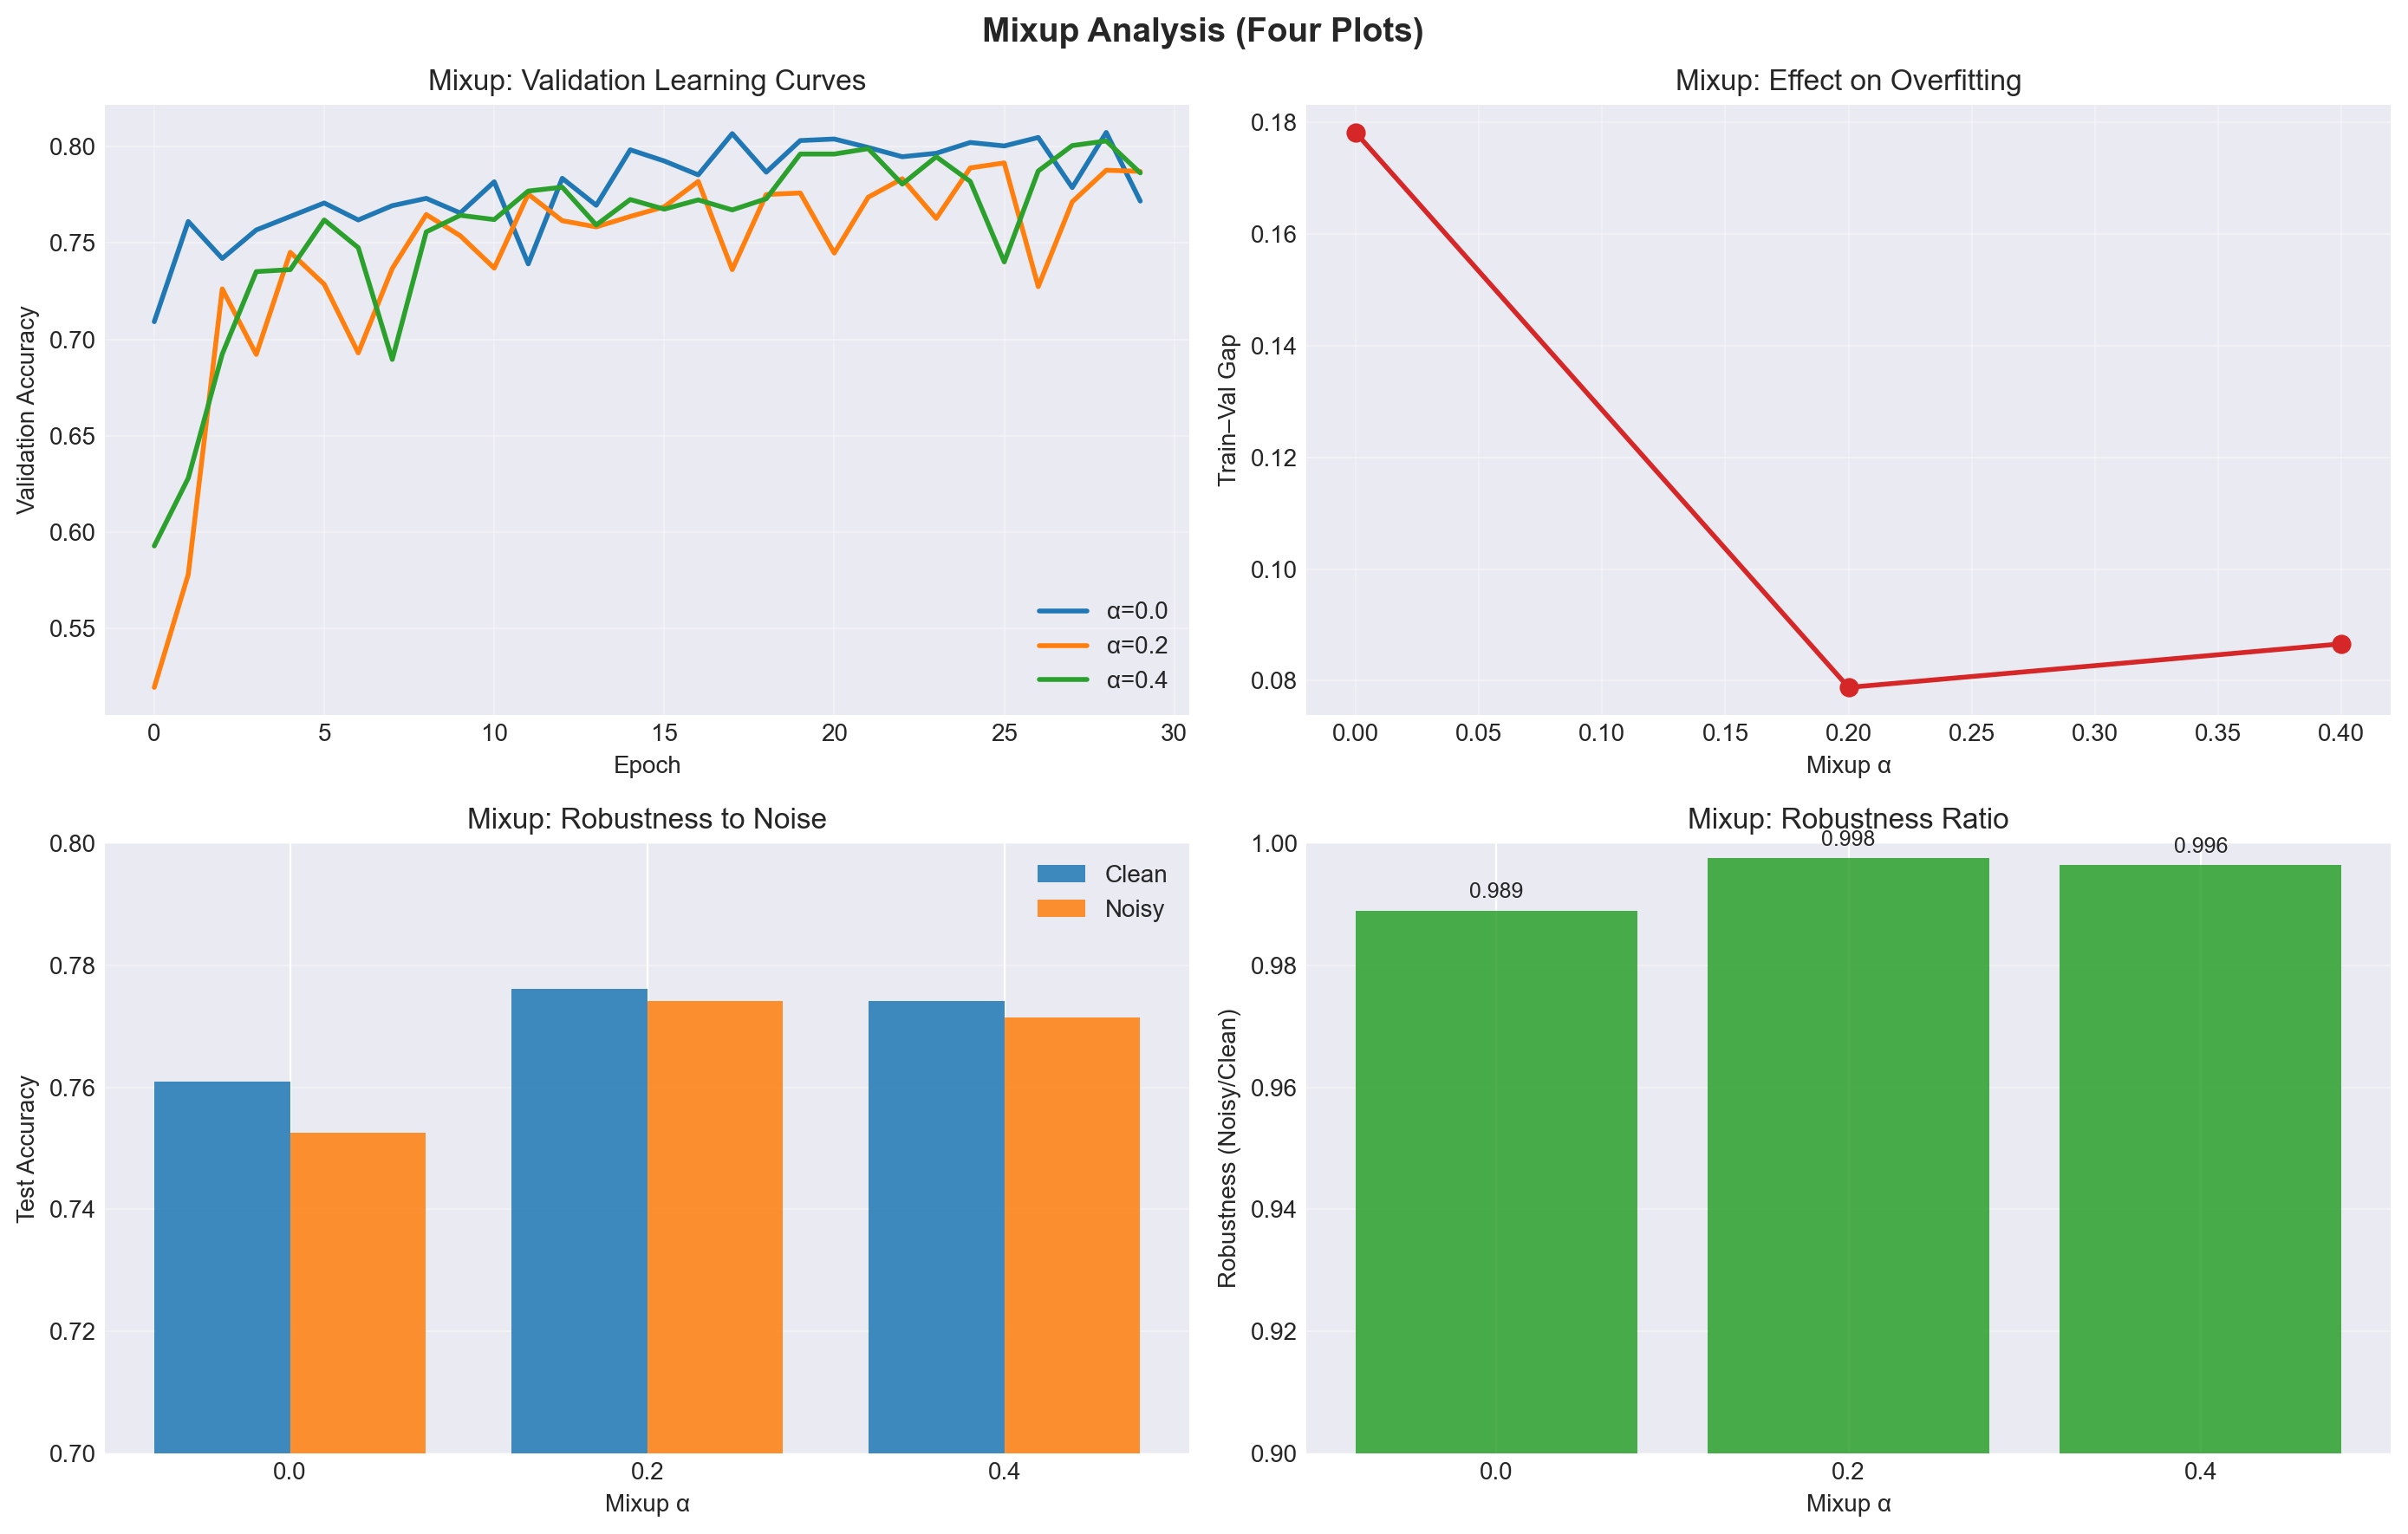


Best α by validation accuracy: 0.2
  Val Acc:  0.787
  Test Acc: 0.776
  Gap:      0.079
  Gap reduction vs α=0.0: 0.099
  Robustness (noisy/clean): 0.998


In [87]:
import numpy as np
import matplotlib.pyplot as plt

# Assumes you already have:
# mixup_alphas, mixup_histories[alpha], mixup_results[alpha]
# where mixup_results[alpha] has: 'val_acc', 'test_acc', 'gap', 'noisy_acc' (and optionally 'robustness')

alphas = list(mixup_alphas)
alphas_sorted = sorted(alphas)

# If 'robustness' not stored, compute it as noisy/clean
for a in alphas_sorted:
    if 'robustness' not in mixup_results[a] and 'noisy_acc' in mixup_results[a]:
        mixup_results[a]['robustness'] = (
            mixup_results[a]['noisy_acc'] / mixup_results[a]['test_acc']
            if mixup_results[a]['test_acc'] > 0 else np.nan
        )

fig, axes = plt.subplots(2, 2, figsize=(14, 9))

# (1) Learning curves (validation)
ax = axes[0, 0]
for a in alphas_sorted:
    ax.plot(mixup_histories[a].history['val_accuracy'],
            label=f'α={a}', linewidth=2)
ax.set_xlabel('Epoch')
ax.set_ylabel('Validation Accuracy')
ax.set_title('Mixup: Validation Learning Curves')
ax.legend()
ax.grid(True, alpha=0.3)

# (2) Gap vs alpha
ax = axes[0, 1]
gaps = [mixup_results[a]['gap'] for a in alphas_sorted]
ax.plot(alphas_sorted, gaps, 'o-', linewidth=2, markersize=7, color='tab:red')
ax.set_xlabel('Mixup α')
ax.set_ylabel('Train–Val Gap')
ax.set_title('Mixup: Effect on Overfitting')
ax.grid(True, alpha=0.3)

# (3) Test accuracy: clean vs noisy
ax = axes[1, 0]
x = np.arange(len(alphas_sorted))
width = 0.38
clean_accs = [mixup_results[a]['test_acc'] for a in alphas_sorted]
noisy_accs = [mixup_results[a]['noisy_acc'] for a in alphas_sorted]
ax.bar(x - width/2, clean_accs, width, label='Clean', alpha=0.85, color='tab:blue')
ax.bar(x + width/2, noisy_accs, width, label='Noisy', alpha=0.85, color='tab:orange')
ax.set_xlabel('Mixup α')
ax.set_ylabel('Test Accuracy')
ax.set_title('Mixup: Robustness to Noise')
ax.set_xticks(x)
ax.set_xticklabels([str(a) for a in alphas_sorted])
ax.set_ylim([0.7,0.8])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# (4) Robustness ratio (Noisy/Clean)
ax = axes[1, 1]
robustness = [mixup_results[a]['robustness'] for a in alphas_sorted]
bars = ax.bar(x, robustness, alpha=0.85, color='tab:green')
ax.set_xlabel('Mixup α')
ax.set_ylabel('Robustness (Noisy/Clean)')
ax.set_title('Mixup: Robustness Ratio')
ax.set_xticks(x)
ax.set_ylim([0.9,1])
ax.set_xticklabels([str(a) for a in alphas_sorted])
for b, r in zip(bars, robustness):
    ax.text(b.get_x() + b.get_width()/2, b.get_height() + 0.002,
            f'{r:.3f}', ha='center', fontsize=9)
ax.grid(True, alpha=0.3, axis='y')

plt.suptitle('Mixup Analysis (Four Plots)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# -------- Printed summary (no textbox) --------
best_alpha = max(alphas_sorted, key=lambda a: mixup_results[a]['val_acc'])
print(f"\nBest α by validation accuracy: {best_alpha}")
print(f"  Val Acc:  {mixup_results[best_alpha]['val_acc']:.3f}")
print(f"  Test Acc: {mixup_results[best_alpha]['test_acc']:.3f}")
print(f"  Gap:      {mixup_results[best_alpha]['gap']:.3f}")
if 0.0 in mixup_results:
    print(f"  Gap reduction vs α=0.0: "
          f"{mixup_results[0.0]['gap'] - mixup_results[best_alpha]['gap']:.3f}")
if 'noisy_acc' in mixup_results[best_alpha]:
    print(f"  Robustness (noisy/clean): {mixup_results[best_alpha]['robustness']:.3f}")

**Mixup Insights:**
- Encourages linear behavior between training examples
- Reduces memorization of training data
- Acts as a strong regularizer
- Particularly effective for image classification

## Summary and Key Takeaways

### What We Learned

Through hands-on experimentation with real data, we've explored the complete regularization toolkit:

1. **Detection First:** Validation sets and learning curves reveal overfitting early
2. **Understanding Why:** The bias-variance tradeoff explains the fundamental challenge
3. **Classical Solutions:** L1/L2, and early stopping each address overfitting differently
4. **Modern Techniques:** Label smoothing and mixup provide additional improvements